<h1 id="header" align="center">
  Car Price Prediction - Exploratory data analysis.
  <img src="https://media.tenor.com/UtkIFBDTlAAAAAAi/car-cars.gif" width="40px"/>
</h1>

---

### Вступление

_EDA (разведочный анализ данных)_ - это процесс изучения основных свойств данных, нахождения в них закономерностей, аномалий и различных распределений, построений моделей с помощью визуализации.

Известно, что не существует единой последовательности операций для выполнения анализа, но есть **базовые пункты**, которые необходимо выполнить.

Данный анализ проводится в рамках изучения дисциплины _"Инижиниринг управления данными"_ в университете ИТМО.
Анализ проводится над **выбранном в kaggle dataset**.

### Информация об dataset.

_Dataset - Car Price Prediction Challenge_ - является набором данных об различных проданных автомобилях с их параметрами.  
Например:
1) Manufacturer (Производитель)
2) Leather interior (Кожаный салон)
3) Fuel type (Тип топлива)  
и т.д ...

Всего таких параметров - **15**.

Ссылка на оригинальный dataset - https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge?resource=download  
Ссылка на dataset, сохраненный в Google Drive - https://docs.google.com/spreadsheets/d/1PMhtD3LqyCzlZMEh-8aDPxre0wPw8v0U/edit?usp=drive_link&ouid=100105970921534140705&rtpof=true&sd=true



### Цель (target) EDA.

Целью EDA является -  __выявление ключевых факторов (features), влияющих на стоимость__.  
  
Также передо мной стоит цель соответствовать следующим __метрикам__ (как минимум первым двум):

![Metrics](./images/Metrics.png)



---

### Этапы EDA.

#### 1) Загрузка данных с сайта и сохранения их в директории для дальнейшего взаимодействия

>[!IMPORTANT]  
>Всегда активируем окружение как рассказано в файле [README.md](../README.md).  
>Не забываем добавить в нашего окружение (Conda+Poetry) необходимые зависимости:
>1) _pandas_
>2) _numpy_
>3) _seaborn_
>4) _matplotlib_
>5) _openpyxl_  
>6) _plotly_

В первую очередь, так как датасет не сохранен в директории проекта, необходимо создать директорию _data_ в корне. А после выполнить в созданную директорию загрузку _сырых данных_ в формате xlsx.    
Здесь же выполним создание кастомной палитры для графиков и подключение основных библиотек для проведения дальнейшего EDA.


In [652]:
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'notebook'

%matplotlib inline


In [ ]:
# colors = ["#e21c34", "#500b28"]
# custom_cmap = mc.LinearSegmentedColormap.from_list("custom_gradient", colors)

# palette = custom_cmap(np.linspace(0.3, 1, 12))
color = "   "
palette = plt.cm.OrRd(
    np.linspace(0.5, 1.0, 12)
)  # настраиваем палитру OrRd, убирая самые светлые оттенки
translate_into_hex = [
    f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for r, g, b, a in palette
]  # переводим палитру в HEX формат для применения в настройках Matplotlib, Seaborn, Plotly


plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 12,
        "figure.figsize": (14, 6),
        "figure.facecolor": f"{color}",
        "axes.facecolor": f"{color}",
        "grid.color": "#f0f0f0",
        "axes.prop_cycle": plt.cycler(color=translate_into_hex),
    }
)

sns.set_theme(
    style="whitegrid",
    palette=translate_into_hex,
    font="Arial",
    font_scale=1.0,
    rc={
        "figure.figsize": (14, 6),
        "figure.facecolor": f"{color}",
        "axes.facecolor": f"{color}",
        "grid.color": "#f0f0f0",
    },
)

custom_template = go.layout.Template()
custom_template.layout.colorway = translate_into_hex
custom_template.layout.font = {"family": "Arial", "size": 12}
custom_template.layout.title = {"x": 0.5, "font": {"size": 16, "weight": "bold"}}
custom_template.layout.paper_bgcolor = f"{color}"
custom_template.layout.plot_bgcolor = f"{color}"


pio.templates["my_custom"] = custom_template
pio.templates.default = "my_custom"

In [654]:
FILE_ID = "1PMhtD3LqyCzlZMEh-8aDPxre0wPw8v0U"  # ID файла на Google Drive
file_url = f"https://drive.google.com/uc?id={FILE_ID}"

pd.set_option("display.max_columns", 20)  # убирает ограничения отображения dataset
pd.set_option("display.max_rows", 150)

data_dir = "../data"  # создаем директорию data в директории notebooks.
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data_path = os.path.join(data_dir, "data_car.xlsx")  # путь до файла dataset

if os.path.isfile(data_path):  # если файл есть в data - читаем, если нет - скачиваем
    df = pd.read_excel(data_path)
    df = df.replace("-", pd.NA)  # убираем все ложные пропуски на NaN
    print(f"{'-'*60}")
    print("Dataset прочитан из директории data...")
    print(f"{'-'*60}")
else:
    response = requests.get(file_url)
    f_path = os.path.join(data_dir, "data_car.xlsx")  # путь до файла dataset
    with open(f_path, "wb") as f:
        f.write(response.content)

    df = pd.read_excel(f_path)
    df = df.replace("-", pd.NA)  # убираем все ложные пропуски на NaN
    print(f"{'-'*60}")
    print("Dataset загружен в директорию data и прочитан...")
    print(f"{'-'*60}")

------------------------------------------------------------
Dataset прочитан из директории data...
------------------------------------------------------------



---

#### 2) Первичный осмотр данных

После _чтения/загрузки dataset из директории/в директорию_ необходимо _осмотреть_ полученные данные и провести _первичную оценку_.  
Поэтому выведем _10 первых и 10 последних значений_ dataset. А также проверим _количество признаков и элементов_.

In [655]:
df.head(10)

ID  Price  Levy Manufacturer     Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS    RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET   Equinox        2011       Jeep   
2  45774419   8467  <NA>        HONDA       FIT        2006  Hatchback   
3  45769185   3607   862         FORD    Escape        2011       Jeep   
4  45809263  11726   446        HONDA       FIT        2014  Hatchback   
5  45802912  39493   891      HYUNDAI  Santa FE        2016       Jeep   
6  45656768   1803   761       TOYOTA     Prius        2010  Hatchback   
7  45816158    549   751      HYUNDAI    Sonata        2013      Sedan   
8  45641395   1098   394       TOYOTA     Camry        2014      Sedan   
9  45756839  26657  <NA>        LEXUS    RX 350        2007       Jeep   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   
5              Yes    Diesel             2  160931 km        4.0   
6              Yes    Hybrid           1.8  258909 km        4.0   
7              Yes    Petrol           2.4  216118 km        4.0   
8              Yes    Hybrid           2.5  398069 km        4.0   
9              Yes    Petrol           3.5  128500 km        6.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4  
5     Automatic        Front  04-May        Left wheel   White        4  
6     Automatic        Front  04-May        Left wheel   White       12  
7     Automatic        Front  04-May        Left wheel    Grey       12  
8     Automatic        Front  04-May        Left wheel   Black       12  
9     Automatic          4x4  04-May        Left wheel  Silver       12

In [656]:
df.tail(10)

ID  Price  Levy   Manufacturer    Model  Prod. year   Category  \
19227  45769427  29793  1053  MERCEDES-BENZ    E 350        2014      Sedan   
19228  45773726    706  1850  MERCEDES-BENZ    E 350        2008      Sedan   
19229  39977395     50  <NA>         TOYOTA    Prius        2008  Hatchback   
19230  45760891    470   645         TOYOTA    Prius        2011  Hatchback   
19231  45772306   5802  1055  MERCEDES-BENZ    E 350        2013      Sedan   
19232  45798355   8467  <NA>  MERCEDES-BENZ  CLK 200        1999      Coupe   
19233  45778856  15681   831        HYUNDAI   Sonata        2011      Sedan   
19234  45804997  26108   836        HYUNDAI   Tucson        2010       Jeep   
19235  45793526   5331  1288      CHEVROLET  Captiva        2007       Jeep   
19236  45813273    470   753        HYUNDAI   Sonata        2012      Sedan   

      Leather interior Fuel type Engine volume    Mileage  Cylinders  \
19227              Yes    Diesel           3.5  219030 km        6.0   
19228              Yes    Diesel           3.5  122874 km        6.0   
19229               No    Hybrid           1.5  150000 km        4.0   
19230              Yes    Hybrid           1.8  307325 km        4.0   
19231              Yes    Diesel           3.5  107800 km        6.0   
19232              Yes       CNG     2.0 Turbo  300000 km        4.0   
19233              Yes    Petrol           2.4  161600 km        4.0   
19234              Yes    Diesel             2  116365 km        4.0   
19235              Yes    Diesel             2   51258 km        4.0   
19236              Yes    Hybrid           2.4  186923 km        4.0   

      Gear box type Drive wheels   Doors       Wheel   Color  Airbags  
19227     Automatic          4x4  04-May  Left wheel   Black       12  
19228     Automatic         Rear  04-May  Left wheel   Black       12  
19229     Automatic        Front  04-May  Left wheel  Silver        6  
19230     Automatic        Front  04-May  Left wheel  Silver       12  
19231     Automatic         Rear  04-May  Left wheel    Grey       12  
19232        Manual         Rear  02-Mar  Left wheel  Silver        5  
19233     Tiptronic        Front  04-May  Left wheel     Red        8  
19234     Automatic        Front  04-May  Left wheel    Grey        4  
19235     Automatic        Front  04-May  Left wheel   Black        4  
19236     Automatic        Front  04-May  Left wheel   White       12

In [657]:
df.shape

(19237, 18)

После этого предлагаю исследовать _в каких типах данных сохранились_ 18 признаков.

In [658]:
df.dtypes

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object


---

#### 3) Операции над данными.

После осмотра данных необходимо выполнить определенные действия для дальнейшего удобства анализа.  
Например - _решение проблемы пустых значений, дубликатов и выбросов, удаление ненужных для текущей target признаков и приведение типов_ 



##### 3.1) Удаление признаков
Так как наша цель заключается в ранжировании признаков по их влиянию на ценообразование, я предлагаю _удалить следующие признаки_:
- cylinders - так как основной акцент на ценообразование будет от типа двигателя, а не от количества цилиндров.
- drive wheels - опять таки минимальный эффект на ценообразование. И кроме того тип привода завязан на моделе авто и его типа.
- color - минимальное влияния на цену автомобиля.
- airbags - минимальное влияние на цену автомобиля.


In [659]:
df = df.drop(["Cylinders", "Drive wheels", "Color", "Airbags"], axis=1)
df.head(5)

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467  <NA>        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage Gear box type   Doors  \
0              Yes    Hybrid           3.5  186005 km     Automatic  04-May   
1               No    Petrol             3  192000 km     Tiptronic  04-May   
2               No    Petrol           1.3  200000 km      Variator  04-May   
3              Yes    Hybrid           2.5  168966 km     Automatic  04-May   
4              Yes    Petrol           1.3   91901 km     Automatic  04-May   

              Wheel  
0        Left wheel  
1        Left wheel  
2  Right-hand drive  
3        Left wheel  
4        Left wheel

##### 3.2) Проверка категориальных признаков
Типы данных могут быть _числовыми и категориальными_. Поэтому следует рассмотреть их точнее и в последствии привести их к нужному типу.

In [660]:
df.select_dtypes(exclude="number").head()

Levy Manufacturer    Model   Category Leather interior Fuel type  \
0  1399        LEXUS   RX 450       Jeep              Yes    Hybrid   
1  1018    CHEVROLET  Equinox       Jeep               No    Petrol   
2  <NA>        HONDA      FIT  Hatchback               No    Petrol   
3   862         FORD   Escape       Jeep              Yes    Hybrid   
4   446        HONDA      FIT  Hatchback              Yes    Petrol   

  Engine volume    Mileage Gear box type   Doors             Wheel  
0           3.5  186005 km     Automatic  04-May        Left wheel  
1             3  192000 km     Tiptronic  04-May        Left wheel  
2           1.3  200000 km      Variator  04-May  Right-hand drive  
3           2.5  168966 km     Automatic  04-May        Left wheel  
4           1.3   91901 km     Automatic  04-May        Left wheel

Как мы видим `Levy` и `Mileage` скорее числовые признаки, нежели нечисловые. В `Levy` имеются пропуски, а в `Mileage` приписка km. _Давайте это исправим._  

Посмотрим на количество в `Levy` _пустых значений_.

In [661]:
df.isna().sum()

ID                     0
Price                  0
Levy                5819
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Engine volume          0
Mileage                0
Gear box type          0
Doors                  0
Wheel                  0
dtype: int64

**Визуальное отображение пропусков:**

Text(0, 0.5, 'Sample Number')

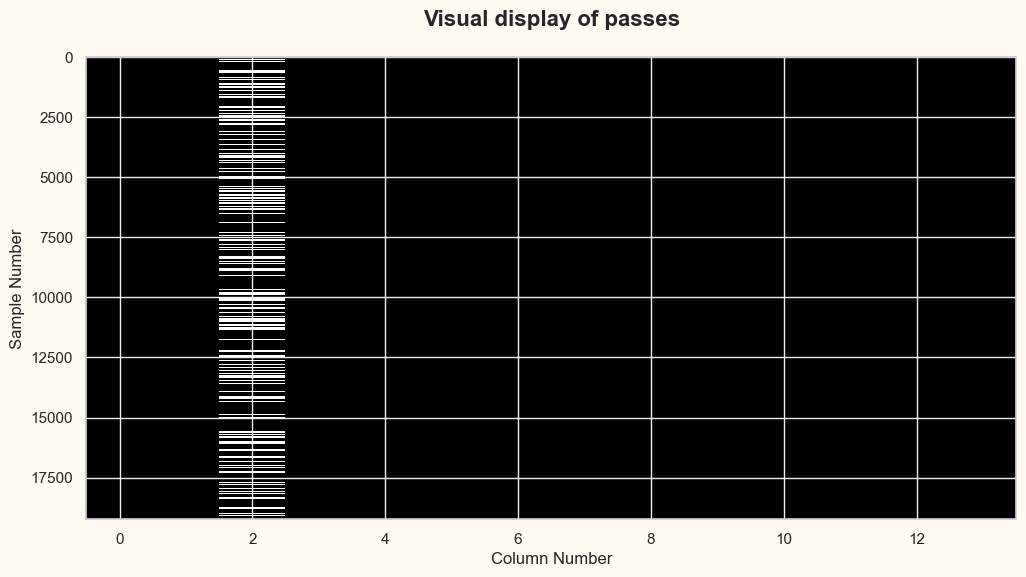

In [662]:
plt.figure(figsize=(12, 6))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.title("Visual display of passes\n", fontsize=16, fontweight="bold")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

Можно увидеть _количество пропусков в признаке `Levy` - очень большое_. И при этом признак, предполагается, одним из важнейших, так как содержит налог на автомобиль.  
Следовательно, лучшим выходом будет выполнить **заполнение по медиане**.

In [663]:
df["Levy"] = df["Levy"].astype(
    "Int16"
)  # данный тип данных позволяет преобразовать признак с пропусками
df["Levy"] = df["Levy"].fillna(df["Levy"].median())
df.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Gear box type       0
Doors               0
Wheel               0
dtype: int64

Далее разберем признак `Mileage`, который необходимо _привести в числовой тип, при этом убрав приписку km_.

In [664]:
df["Mileage"] = df["Mileage"].str.replace(" km", "", regex=False)
df["Mileage"].head(10)

0    186005
1    192000
2    200000
3    168966
4     91901
5    160931
6    258909
7    216118
8    398069
9    128500
Name: Mileage, dtype: object

In [665]:
df["Mileage"] = df["Mileage"].astype("int32")
df["Mileage"].head(10)

0    186005
1    192000
2    200000
3    168966
4     91901
5    160931
6    258909
7    216118
8    398069
9    128500
Name: Mileage, dtype: int32

Еще раз выведем категориальные признаки, чтобы проверить не упустили ли мы что-то.

In [666]:
df.select_dtypes(exclude="number").head()

Manufacturer    Model   Category Leather interior Fuel type Engine volume  \
0        LEXUS   RX 450       Jeep              Yes    Hybrid           3.5   
1    CHEVROLET  Equinox       Jeep               No    Petrol             3   
2        HONDA      FIT  Hatchback               No    Petrol           1.3   
3         FORD   Escape       Jeep              Yes    Hybrid           2.5   
4        HONDA      FIT  Hatchback              Yes    Petrol           1.3   

  Gear box type   Doors             Wheel  
0     Automatic  04-May        Left wheel  
1     Tiptronic  04-May        Left wheel  
2      Variator  04-May  Right-hand drive  
3     Automatic  04-May        Left wheel  
4     Automatic  04-May        Left wheel

Признак `Engine volume` оставляем _нечисловым_, так как помимо объема двигателя в признаке указывается - *с турбонаддувом двигатель или нет*

##### 3.3) Проверка числовых признаков
Разберем _числовые признаки_ dataset. Кроме того дополнительно проверим нахождения тут измененных признаков из пункта выше.

In [667]:
df.select_dtypes(include="number").head()

ID  Price  Levy  Prod. year  Mileage
0  45654403  13328  1399        2010   186005
1  44731507  16621  1018        2011   192000
2  45774419   8467   781        2006   200000
3  45769185   3607   862        2011   168966
4  45809263  11726   446        2014    91901

**Все хорошо**, теперь можно рассмотреть количество уникальных значений в каждом из признаков. Это поможет точнее выбрать тип для приведения.

In [668]:
uniq_val = df.select_dtypes(include="number").nunique().sort_values()

fig = px.bar(
    x=uniq_val.index,
    y=uniq_val.values,
    labels={"x": "Features", "y": "Count"},
    # template="seaborn",
)

fig.update_layout(
    xaxis_tickangle=0,
    showlegend=False,
    title="Unique values in each feature\n",
)

fig.update_traces(texttemplate="%{y}", textposition="outside")

fig.show()

##### 3.4) Проверка дубликатов

Так как мы хотим добиться уникальности записей, то необходимо провести над нашими данными _проверку дубликатов_ по их ID.

In [669]:
df.shape

(19237, 14)

In [670]:
duplic_rows_df = df[df.duplicated()]
duplic_rows_df.shape

(313, 14)

Их оказалось не так много, учитывая весь объем датасета. _Поэтому мы можем их смело удалить_.

In [671]:
df = df.drop_duplicates()
df.shape

(18924, 14)

##### 3.5) Переименование признаков

Анализируя данные мы пришли к выводу, что необходимо переименовать некоторые признаки, так как они мало отражают содержащиеся в них сведения.  
Все переименования будут указны также в файле [NAMING.txt](../docs/NAMING.txt) в директории *docs*.  
Перед этим выведем все названия.

In [672]:
df.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467   781        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume  Mileage Gear box type   Doors  \
0              Yes    Hybrid           3.5   186005     Automatic  04-May   
1               No    Petrol             3   192000     Tiptronic  04-May   
2               No    Petrol           1.3   200000      Variator  04-May   
3              Yes    Hybrid           2.5   168966     Automatic  04-May   
4              Yes    Petrol           1.3    91901     Automatic  04-May   

              Wheel  
0        Left wheel  
1        Left wheel  
2  Right-hand drive  
3        Left wheel  
4        Left wheel

In [673]:
df = df.rename(
    columns={
        "Levy": "Tax",
        "Prod. year": "Release_year",
        "Category": "Car_type",
        "Gear box type": "Transmission_type",
    }
)
df.head()

ID  Price   Tax Manufacturer    Model  Release_year   Car_type  \
0  45654403  13328  1399        LEXUS   RX 450          2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox          2011       Jeep   
2  45774419   8467   781        HONDA      FIT          2006  Hatchback   
3  45769185   3607   862         FORD   Escape          2011       Jeep   
4  45809263  11726   446        HONDA      FIT          2014  Hatchback   

  Leather interior Fuel type Engine volume  Mileage Transmission_type   Doors  \
0              Yes    Hybrid           3.5   186005         Automatic  04-May   
1               No    Petrol             3   192000         Tiptronic  04-May   
2               No    Petrol           1.3   200000          Variator  04-May   
3              Yes    Hybrid           2.5   168966         Automatic  04-May   
4              Yes    Petrol           1.3    91901         Automatic  04-May   

              Wheel  
0        Left wheel  
1        Left wheel  
2  Right-hand drive  
3        Left wheel  
4        Left wheel

##### 3.6) Обнаружение и обработка выбросов в числовых признаках

Важно предупредить момент выбросов и ошибочных огромных значений в числовых параметрах. Особенно перед приведением типов.  
Такие выбросы будут негативно влиять на наш конечный вывод, что приведет к **некорректному решению поставленной цели**.  
Вызовем для отображения снова числовые параметры.

In [674]:
df.select_dtypes(include="number").head()

ID  Price   Tax  Release_year  Mileage
0  45654403  13328  1399          2010   186005
1  44731507  16621  1018          2011   192000
2  45774419   8467   781          2006   200000
3  45769185   3607   862          2011   168966
4  45809263  11726   446          2014    91901

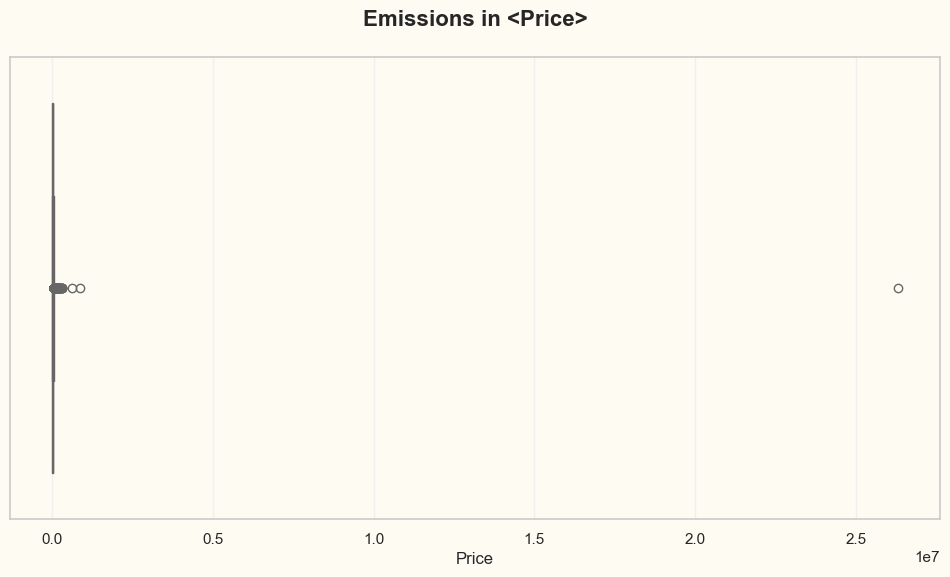

In [675]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Price"])
plt.title("Emissions in <Price>\n", fontsize=16, fontweight="bold")
plt.show()

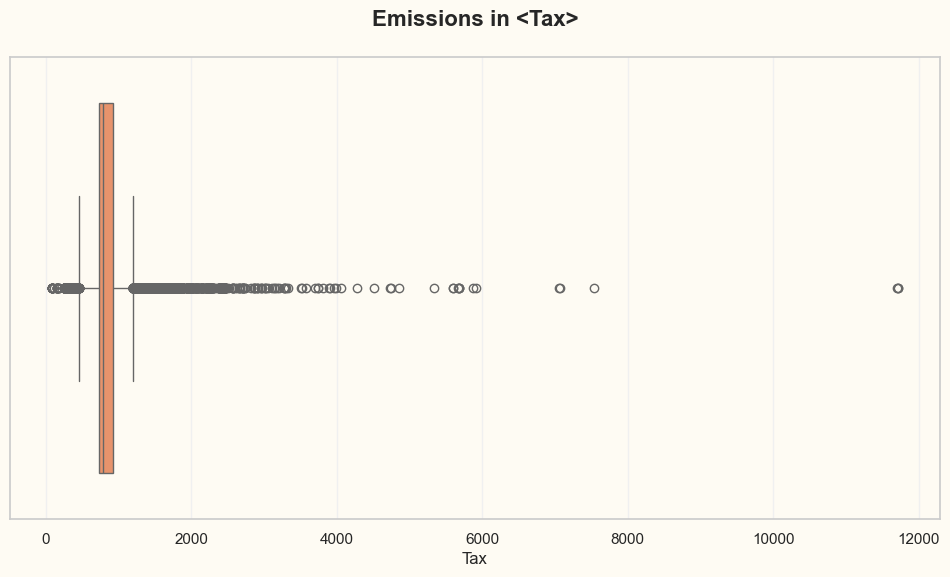

In [676]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Tax"])
plt.title("Emissions in <Tax>\n", fontsize=16, fontweight="bold")
plt.show()

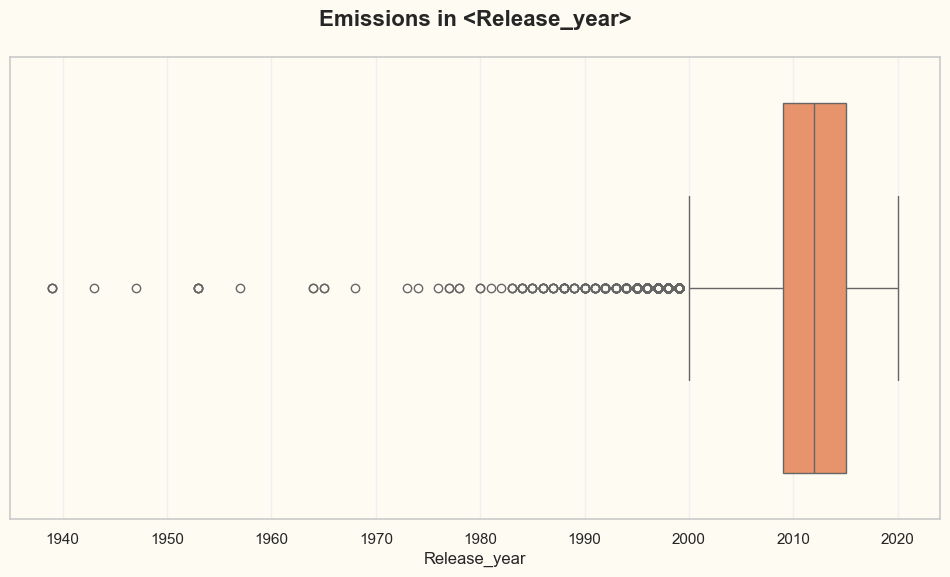

In [677]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Release_year"])
plt.title("Emissions in <Release_year>\n", fontsize=16, fontweight="bold")
plt.show()

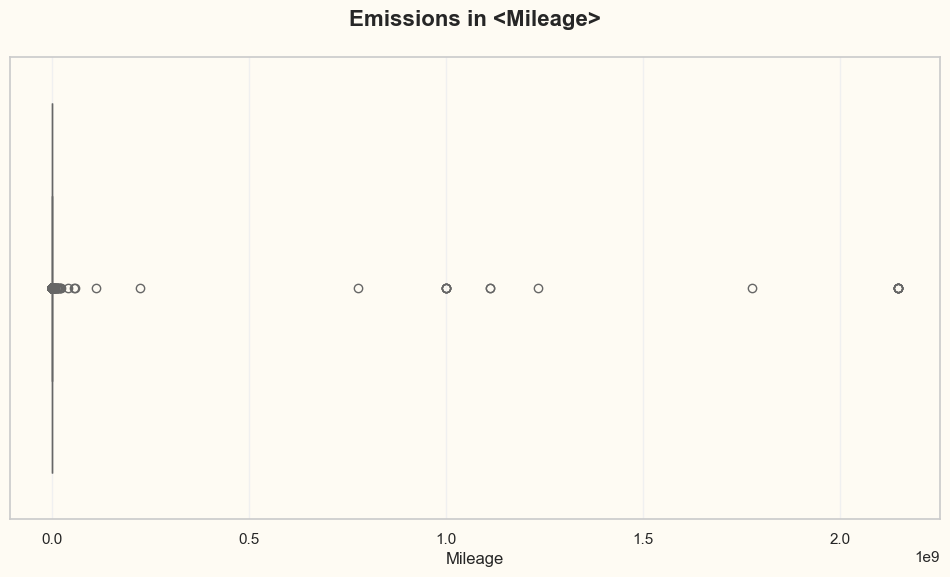

In [678]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Mileage"])
plt.title("Emissions in <Mileage>\n", fontsize=16, fontweight="bold")
plt.show()

Как видно по графикам - проблемы **есть**. А конкретно в признаках `Price`, `Tax`, `Mileage`.  
Это необходимо решать. Начнем с признака `Price`.

In [679]:
df["Price"].nlargest(5)

16983    26307500
8541       872946
1225       627220
5008       308906
9367       297930
Name: Price, dtype: int64

Давайте посмотрим какие автомобили имеют такой ценник.

In [680]:
df[df["Price"].isin([26307500, 872946, 627220])]

ID     Price   Tax   Manufacturer           Model  Release_year  \
1225   45795524    627220   781  MERCEDES-BENZ  G 65 AMG 63AMG          2020   
8541   45761204    872946  2067    LAMBORGHINI            Urus          2019   
16983  45812886  26307500   781           OPEL           Combo          1999   

          Car_type Leather interior Fuel type Engine volume  Mileage  \
1225          Jeep              Yes    Petrol     6.3 Turbo        0   
8541     Universal              Yes    Petrol             4     2531   
16983  Goods wagon               No    Diesel           1.7    99999   

      Transmission_type   Doors       Wheel  
1225          Tiptronic  04-May  Left wheel  
8541          Tiptronic  04-May  Left wheel  
16983            Manual  02-Mar  Left wheel

Мы нашли и проанализировали выбросы и первые два автомобиля - имеют адекватную цену. А вот третий - _Opel Combo_ не может стоить такую сумму. Это необходимо исправить.

In [681]:
df["Price"] = df["Price"].mask(df["Price"] > 900000, df["Price"].median())
df["Price"].nlargest(5)

8541     872946
1225     627220
5008     308906
9367     297930
14839    297930
Name: Price, dtype: int64

_Что мы сделали?_  
Так как в признаке мы обнаружили и определили единичный выброс с суммой, которая невозможна для того типа автомобиля (<ins>цены указаны в долларах</ins>).  
Поэтому было принято решение заменить этот выброс на **медианное значение**.  
Ниже снова выведем график `Price`:

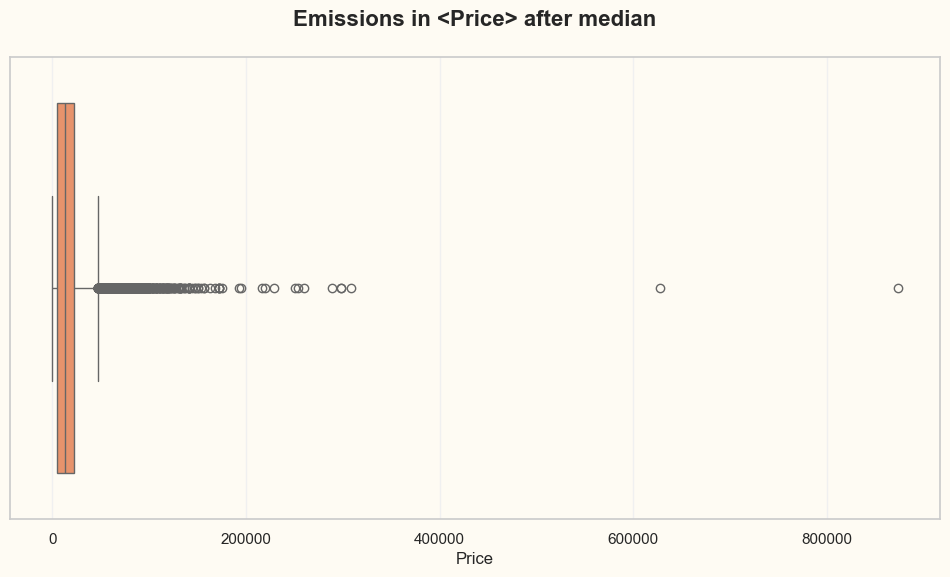

In [682]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Price"])
plt.title("Emissions in <Price> after median\n", fontsize=16, fontweight="bold")
plt.show()

Теперь проанализируем `Tax`

In [683]:
df["Tax"].nlargest(10)

115      11714
18984    11714
18957    11706
17117     7536
3994      7063
2159      7058
5529      5908
5367      5877
17767     5681
2323      5679
Name: Tax, dtype: Int16

Опять посмотрим на автомобили:

In [684]:
df[df["Tax"].isin([11714, 11706, 7536, 7063, 7058])]

ID  Price    Tax   Manufacturer      Model  Release_year  \
115    45534351  11917  11714  MERCEDES-BENZ  E 500 AMG          2003   
2159   45804871  10349   7058         SUBARU     Legacy          2005   
3994   45782188  13172   7063         TOYOTA    Alphard          2003   
17117  45781442   7213   7536     MITSUBISHI     Pajero          2000   
18957  44674964  14740  11706  MERCEDES-BENZ  E 500 AVG          2005   
18984  45221191  11917  11714  MERCEDES-BENZ      E 500          2003   

      Car_type Leather interior Fuel type Engine volume  Mileage  \
115      Sedan              Yes    Petrol             5   150000   
2159     Sedan              Yes    Petrol             3   147000   
3994   Minivan              Yes       LPG             3   190000   
17117     Jeep              Yes       CNG           3.2   210000   
18957    Sedan              Yes    Petrol             5    56000   
18984    Sedan              Yes    Petrol             5   150000   

      Transmission_type   Doors             Wheel  
115           Tiptronic  04-May  Right-hand drive  
2159          Tiptronic  04-May  Right-hand drive  
3994          Automatic  04-May  Right-hand drive  
17117         Automatic  04-May  Right-hand drive  
18957         Tiptronic  04-May  Right-hand drive  
18984         Tiptronic  04-May  Right-hand drive

Просмотрев автомобили с такими налогами стало понятно - **выбросов в признаке НЕТ!**

Теперь проверим признак `Mileage`:

In [685]:
df["Mileage"].nlargest(10)

2278     2147483647
6157     2147483647
11901    2147483647
12734    2147483647
15347    2147483647
15393    2147483647
19167    2147483647
17582    1777777778
7724     1234567899
9524     1111111111
Name: Mileage, dtype: int32

В этом признаке явно что-то аномальное (магические числа). Проверим с помощью _межквартильного размаха(IQR)_.  
<ins>Определение IQR</ins> - это статистическая мера, показывающая разброс средних 50% данных, отсекая крайние значения.

In [686]:
Q1_Mil = df["Mileage"].quantile(0.25)
Q3_Mil = df["Mileage"].quantile(0.75)
IQR_Mil = Q3_Mil - Q1_Mil
up_bound_Mil = Q3_Mil + 1.5 * IQR_Mil
down_bound_Mil = Q1_Mil - 1.5 * IQR_Mil

errors = df[df["Mileage"] > up_bound_Mil]
errors_type_2 = df[df["Mileage"] < down_bound_Mil]
len(errors)  # количество записей-выбросов выше верхней границы

635

In [687]:
len(errors_type_2)  # количество записей-выбросов ниже нижней границы

0

Делаем вывод, что 635 значений - у нас точно являются выбросами или некорректными значениями.  
Так как у нас почти __19000 строчек__, то принимаем решение по удалению этих выбросов.

In [688]:
df = df[
    df["Mileage"] <= up_bound_Mil
]  # оставляем в Mileage только те значения, которые попали до верхней границы
df["Mileage"].nlargest(10)

1086     367053
7259     367000
14709    367000
4961     366869
8948     366869
9125     366869
10944    366869
15132    366869
16628    366869
9840     365810
Name: Mileage, dtype: int32

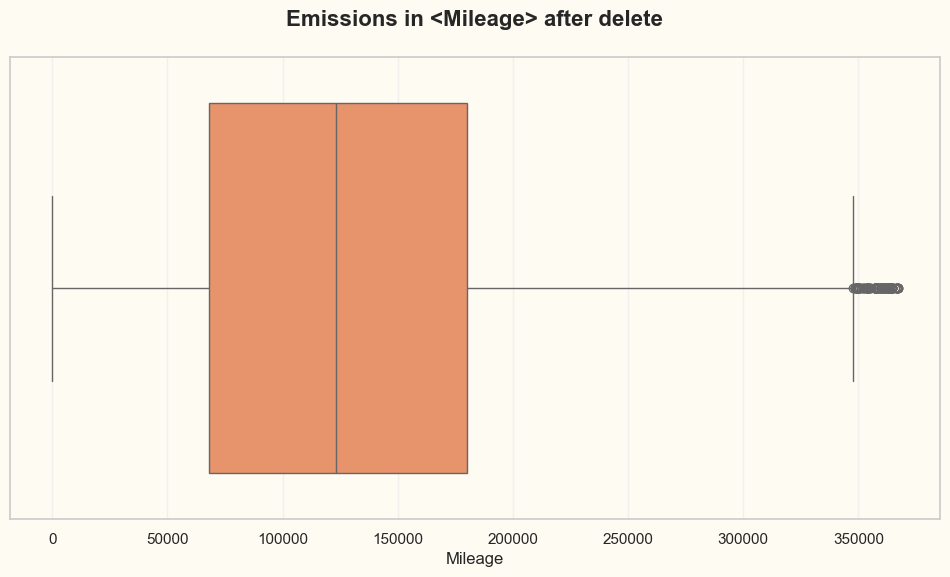

In [689]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Mileage"])
plt.title("Emissions in <Mileage> after delete\n", fontsize=16, fontweight="bold")
plt.show()

_Вывод_ - мы задетектировали выбросы в числовых признаках и их убрали.

##### 3.7) Приведение типов и сохранение в формате .parquet

Дальнейший анализ предполагает точный результат, поэтому я хотел бы использовать максимально обработанные и скорректированные данные. И в быстро работающем формате .parquet.  
Выведем признаки и их типы:

In [690]:
df.dtypes

ID                    int64
Price                 int64
Tax                   Int16
Manufacturer         object
Model                object
Release_year          int64
Car_type             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage               int32
Transmission_type    object
Doors                object
Wheel                object
dtype: object

Выполним _приведение типов_:

In [691]:
df["ID"] = df["ID"].astype("int32")
df["Price"] = df["Price"].astype("int32")
df["Manufacturer"] = df["Manufacturer"].astype("category")
df["Model"] = df["Model"].astype("category")
df["Tax"] = df["Tax"].astype("int32")
df["Release_year"] = df["Release_year"].astype("int16")
df["Car_type"] = df["Car_type"].astype("category")
df["Have a leather interior?"] = (
    df["Leather interior"].map({"No": 0, "Yes": 1}).astype("bool")
)  # добавляем к оригинальному признаку  булевый признак.

df["Car have a left wheel?"] = (
    df["Wheel"].map({"Right-hand drive": 0, "Left wheel": 1}).astype("bool")
)

df["Fuel type"] = df["Fuel type"].astype("category")
df["Transmission_type"] = df["Transmission_type"].astype("category")
df["Doors"] = df["Doors"].astype("category")
df[["Leather interior", "Wheel"]] = df[
    ["Have a leather interior?", "Car have a left wheel?"]
]  # заменяем оригинал на булевый.
df = df.drop(
    columns=["Have a leather interior?", "Car have a left wheel?"]
)  # удаляем дополнительные признаки.

df.rename(
    columns={"Leather interior": "Have a leather interior?"}, inplace=True
)  # переименовываем.
df.rename(columns={"Wheel": "Car have a left wheel?"}, inplace=True)

df.dtypes

ID                             int32
Price                          int32
Tax                            int32
Manufacturer                category
Model                       category
Release_year                   int16
Car_type                    category
Have a leather interior?        bool
Fuel type                   category
Engine volume                 object
Mileage                        int32
Transmission_type           category
Doors                       category
Car have a left wheel?          bool
dtype: object

Мы привели типы и теперь сохраним наш новый рабочий dataset в формате .parquet

In [692]:
fi_path = os.path.join(data_dir, "data_car.parquet")  # путь до файла dataset
df.to_parquet(fi_path)  # сохраняем dataset в .parquet
df_par = pd.read_parquet(fi_path)
df_par.head()

ID  Price   Tax Manufacturer    Model  Release_year   Car_type  \
0  45654403  13328  1399        LEXUS   RX 450          2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox          2011       Jeep   
2  45774419   8467   781        HONDA      FIT          2006  Hatchback   
3  45769185   3607   862         FORD   Escape          2011       Jeep   
4  45809263  11726   446        HONDA      FIT          2014  Hatchback   

   Have a leather interior? Fuel type Engine volume  Mileage  \
0                      True    Hybrid           3.5   186005   
1                     False    Petrol             3   192000   
2                     False    Petrol           1.3   200000   
3                      True    Hybrid           2.5   168966   
4                      True    Petrol           1.3    91901   

  Transmission_type   Doors  Car have a left wheel?  
0         Automatic  04-May                    True  
1         Tiptronic  04-May                    True  
2          Variator  04-May                   False  
3         Automatic  04-May                    True  
4         Automatic  04-May                    True


---

#### 4) Проверка по метрикам

Решим проходит ли наш dataset по метрикам - **Completeness и Uniqueness**.

In [693]:
completeness = df_par.count() / len(df_par)
uniqueness = df_par["ID"].nunique() / len(
    df_par["ID"]
)  # так как этот параметр напрямую отвечает за уникальность значений в признаках.
print(completeness)
print(f"{'-'*60}")
print(f"ID = {uniqueness}")

ID                          1.0
Price                       1.0
Tax                         1.0
Manufacturer                1.0
Model                       1.0
Release_year                1.0
Car_type                    1.0
Have a leather interior?    1.0
Fuel type                   1.0
Engine volume               1.0
Mileage                     1.0
Transmission_type           1.0
Doors                       1.0
Car have a left wheel?      1.0
dtype: float64
------------------------------------------------------------
ID = 1.0



---

#### 5) Валидация данных

Проведем валидацию корректности данных с помощью _assert_ и команд _try/except_.  
Если проверки будут успешными - то переходим к графикам и диаграммам.

In [694]:
try:
    assert (df_par["Price"].dtype == "int32") and ((df_par["Price"] >= 0).all())
    print("Валидация Price - успешна")
except AssertionError:
    print("ERROR in Price")

try:
    assert (df_par["Tax"].dtype == "int32") and ((df_par["Tax"] >= 0).all())
    print("Валидация Tax - успешна")
except AssertionError:
    print("ERROR in Tax")

try:
    assert (
        (df_par["Release_year"].dtype == "int16")
        and ((df_par["Release_year"] >= 1900).all())
        and ((df_par["Release_year"] <= 2100).all())
    )
    print("Валидация Release_year - успешна")
except AssertionError:
    print("ERROR in Release_year")

try:
    assert (df_par["Have a leather interior?"].dtype == "bool") and (
        (df_par["Have a leather interior?"].isin([True, False]).all())
    )
    print("Валидация Have a leather interior? - успешна")
except AssertionError:
    print("ERROR in Have a leather interior?")

try:
    assert (df_par["Mileage"].dtype == "int32") and ((df_par["Mileage"] >= 0).all())
    print("Валидация Mileage - успешна")
except AssertionError:
    print("ERROR in Mileage")

try:
    assert (df_par["Car have a left wheel?"].dtype == "bool") and (
        (df_par["Car have a left wheel?"].isin([True, False]).all())
    )
    print("Валидация Car have a left wheel? - успешна")
except AssertionError:
    print("ERROR in Car have a left wheel?")

Валидация Price - успешна
Валидация Tax - успешна
Валидация Release_year - успешна
Валидация Have a leather interior? - успешна
Валидация Mileage - успешна
Валидация Car have a left wheel? - успешна


__Валидация числовых и булевых признаков__ - прошла успешно!  


---

#### 6) Анализы данных для решения задачи



##### 6.1) Анализ распределения целевой переменной - Price

Повторно озвучиваем цель - **провести ранжирование признаков по влиянию на ценообразования автомобиля**.  
Следовательно основной целевой переменной мы берем признак `Price`. Выведем гистограмму и boxplot.

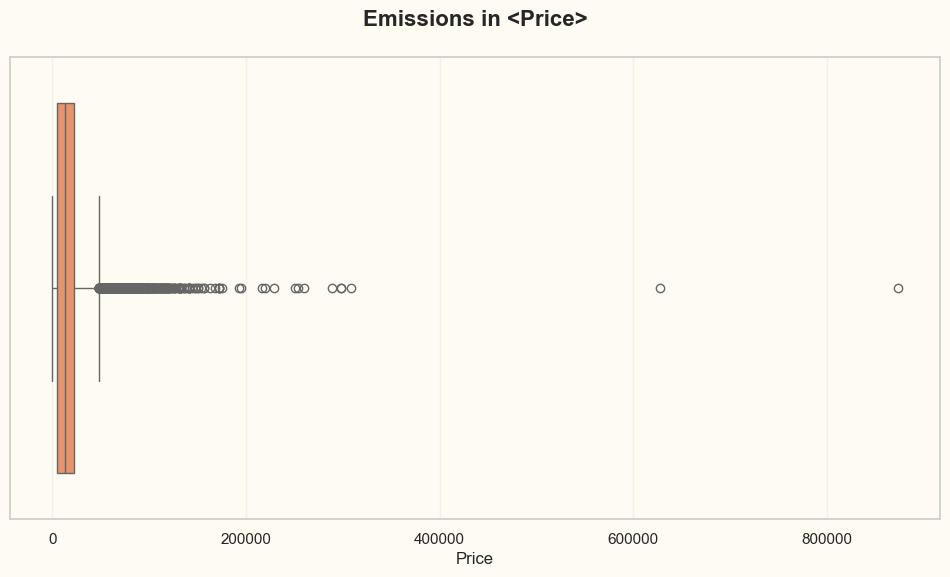

In [695]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Price"])
plt.title("Emissions in <Price>\n", fontsize=16, fontweight="bold")
plt.show()

In [696]:
fig = px.histogram(
    df_par,
    x="Price",
    nbins=50,
    # template="seaborn",
)

fig.update_layout(
    xaxis_tickangle=0,
    showlegend=False,
    title="Price distribution",
)

fig.show()

Как мы обсуждали выше - **две точки с ценой от 600000 долларов - это нормальная цена для представленных там автомобилей**.

##### 6.2) Построение корреляционной карты и точечных графиков для коррелирующих признаков

Для определения корреляций между признаками воспользуемся методами `heatmap` и `scatterplot`.

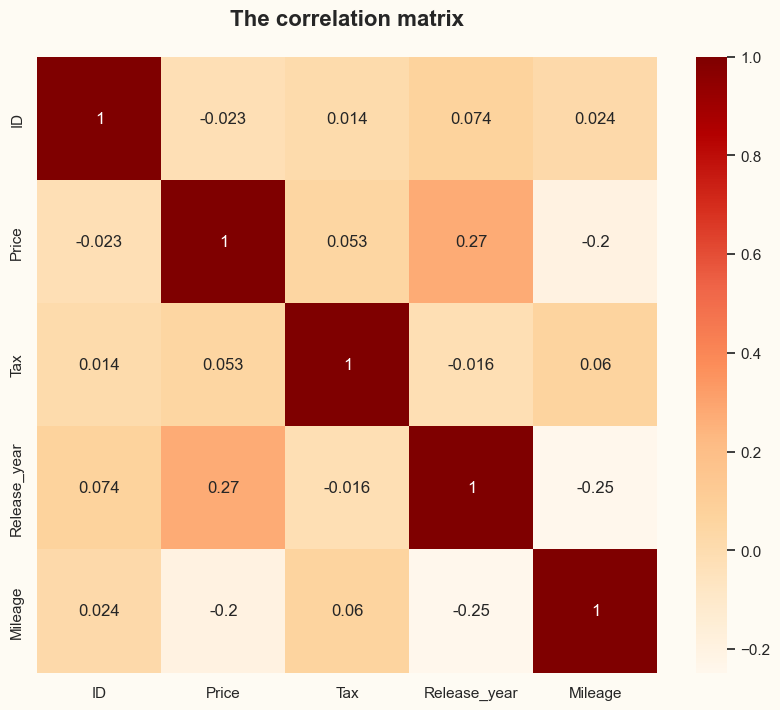

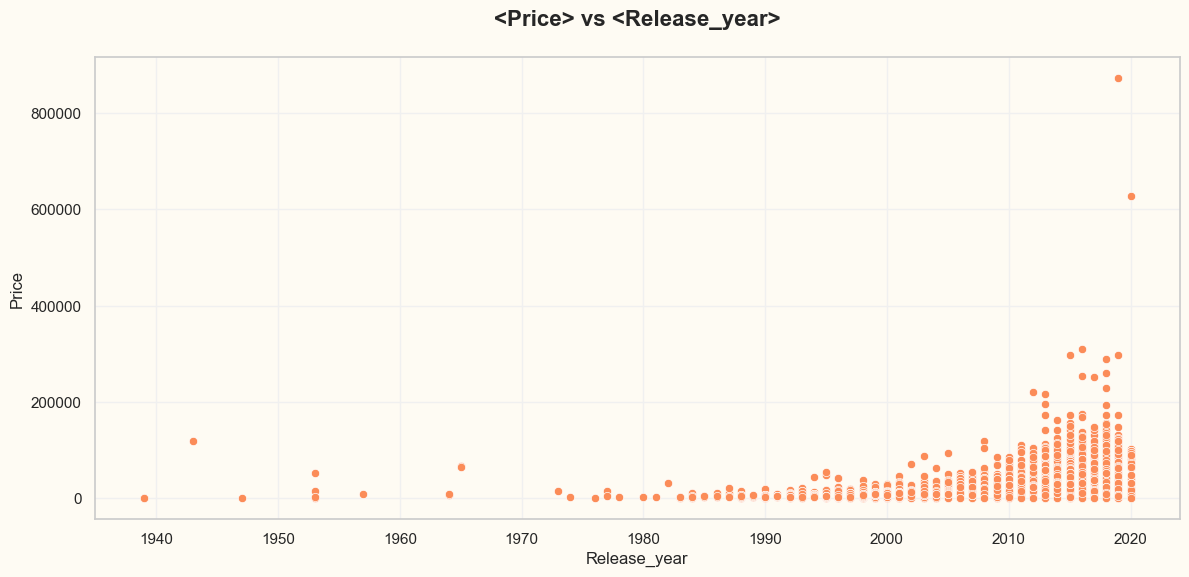

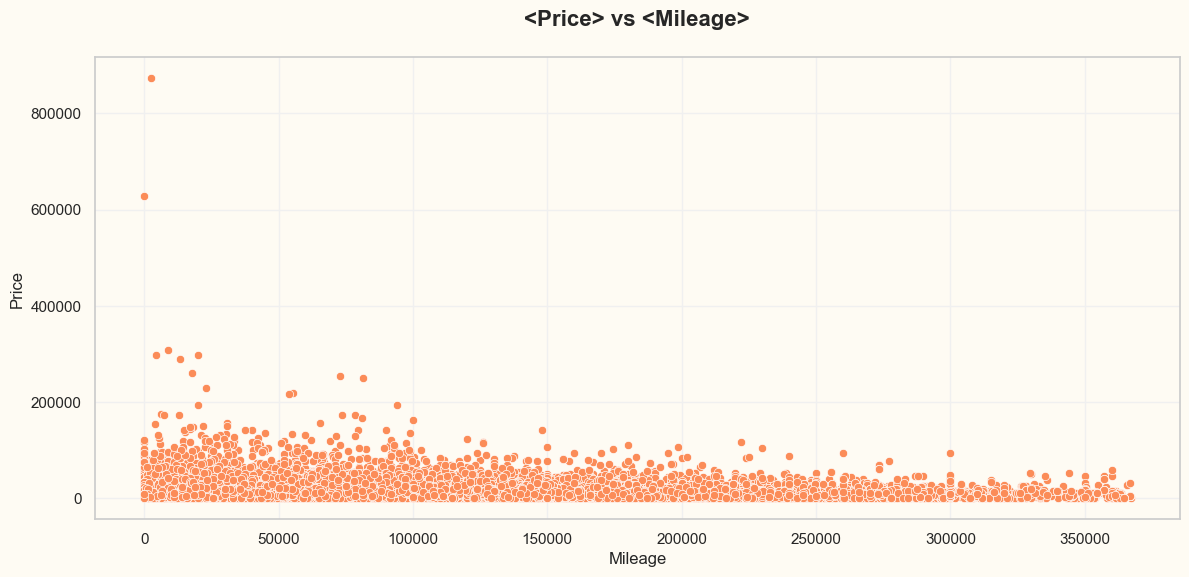

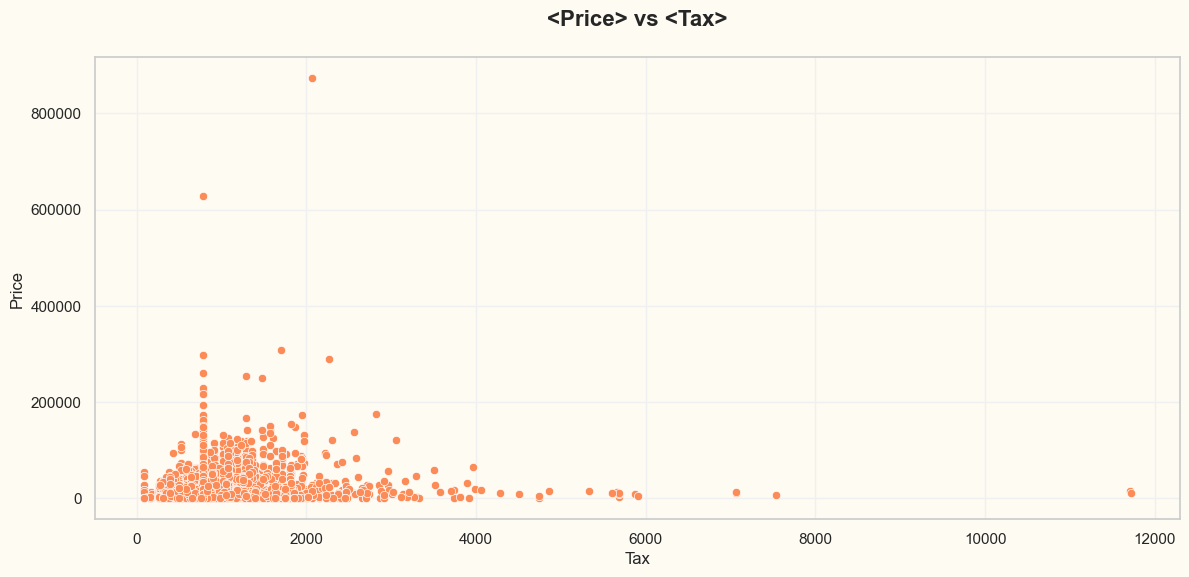

In [697]:
num_df_par = df_par.select_dtypes(include="number").columns

plt.figure(figsize=(10, 8))
sns.heatmap(df_par[num_df_par].corr(), annot=True, cmap="OrRd")
plt.title("The correlation matrix\n", fontsize=16, fontweight="bold")
plt.show()

top_corr_ft = (
    df_par[num_df_par].corr()["Price"].abs().sort_values(ascending=False).index[1:4]
)
for features in top_corr_ft:
    sns.scatterplot(data=df_par, x=features, y="Price")
    plt.title(f"<Price> vs <{features}>\n", fontsize=16, fontweight="bold")
    plt.show()

Предлагаю рассмотреть распределения признаков `Release_year`, `Mileage`, `Tax`:

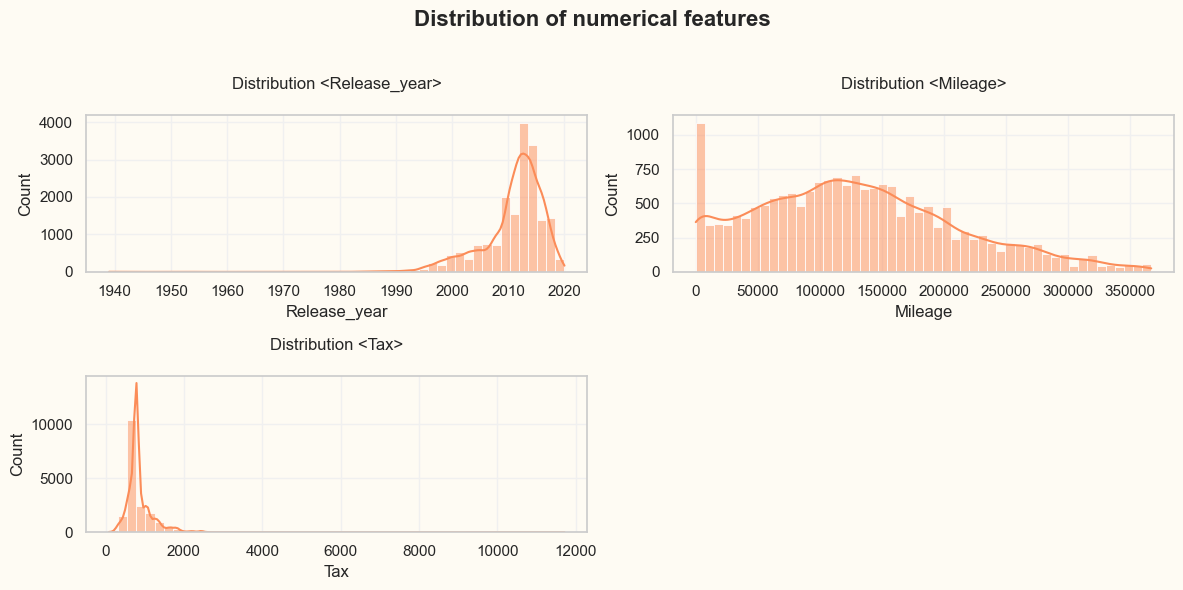

In [698]:
num_cols = ["Release_year", "Mileage", "Tax"]  # числовые признаки

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
fig.suptitle("Distribution of numerical features\n", fontsize=16, fontweight="bold")

axes_flat = axes.flat  # преобразование массива 2х2 в массив 1:4 для перебора элементов

for i, col in enumerate(num_cols):
    sns.histplot(data=df_par, x=col, ax=axes_flat[i], bins=50, kde=True)
    axes_flat[i].set_title(f"Distribution <{col}>\n")
    axes_flat[i].tick_params(axis="x", rotation=0)

for i in range(len(num_cols), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

_Промежуточный вывод_ - мы получили наши точечные графики корреляции признаков с основным признаком `Price`.
  
Сразу заметно, что эти графики представляют собой своеобразное "облако из точек" и в некоторых ситуациях, например с признаками `Mileage` и `Pelease_year`, можно заметить что-то похожее на, в первом случае **нисходящую прямую линию**, а во втором случае **восходящую прямую линию**.  
Что может говорить нам следующее:
- С увеличением пробега - цена автомобиля падает.
- Чем новее выпущен автомобиль - тем выше его цена.

Но не стоит забыть, что в основном это "облака из точек", т.е интерпретируя это показывает на достаточно слабую зависимость.

Также гипотеза о слабой зависимости `Price` от числовых параметров подтверждается коррелляционной матрицей. Так как максимальное число в ней, из положительных естественно, это 0,27 - что, исходя из определения <ins>коэффициента корреляции Пирсона</ins>, говорит нам о слабой положительной корреляции.

Кроме того из распределений сделаем следующие выводы:
1) В основном в нем представлены автомобили выпуска __2000-2018 годов__.
2) Среднем значение __пробега__ - примерно от 100000 до 150000 км.
3) Средний __налог__ на авто - 500 долларов

_А эти данные указывают на то, что датасет создавался на основе реальных величин и реальных показателей в автомобильной промышленности_.

Теперь проведем проверку _категориальных признаков_:

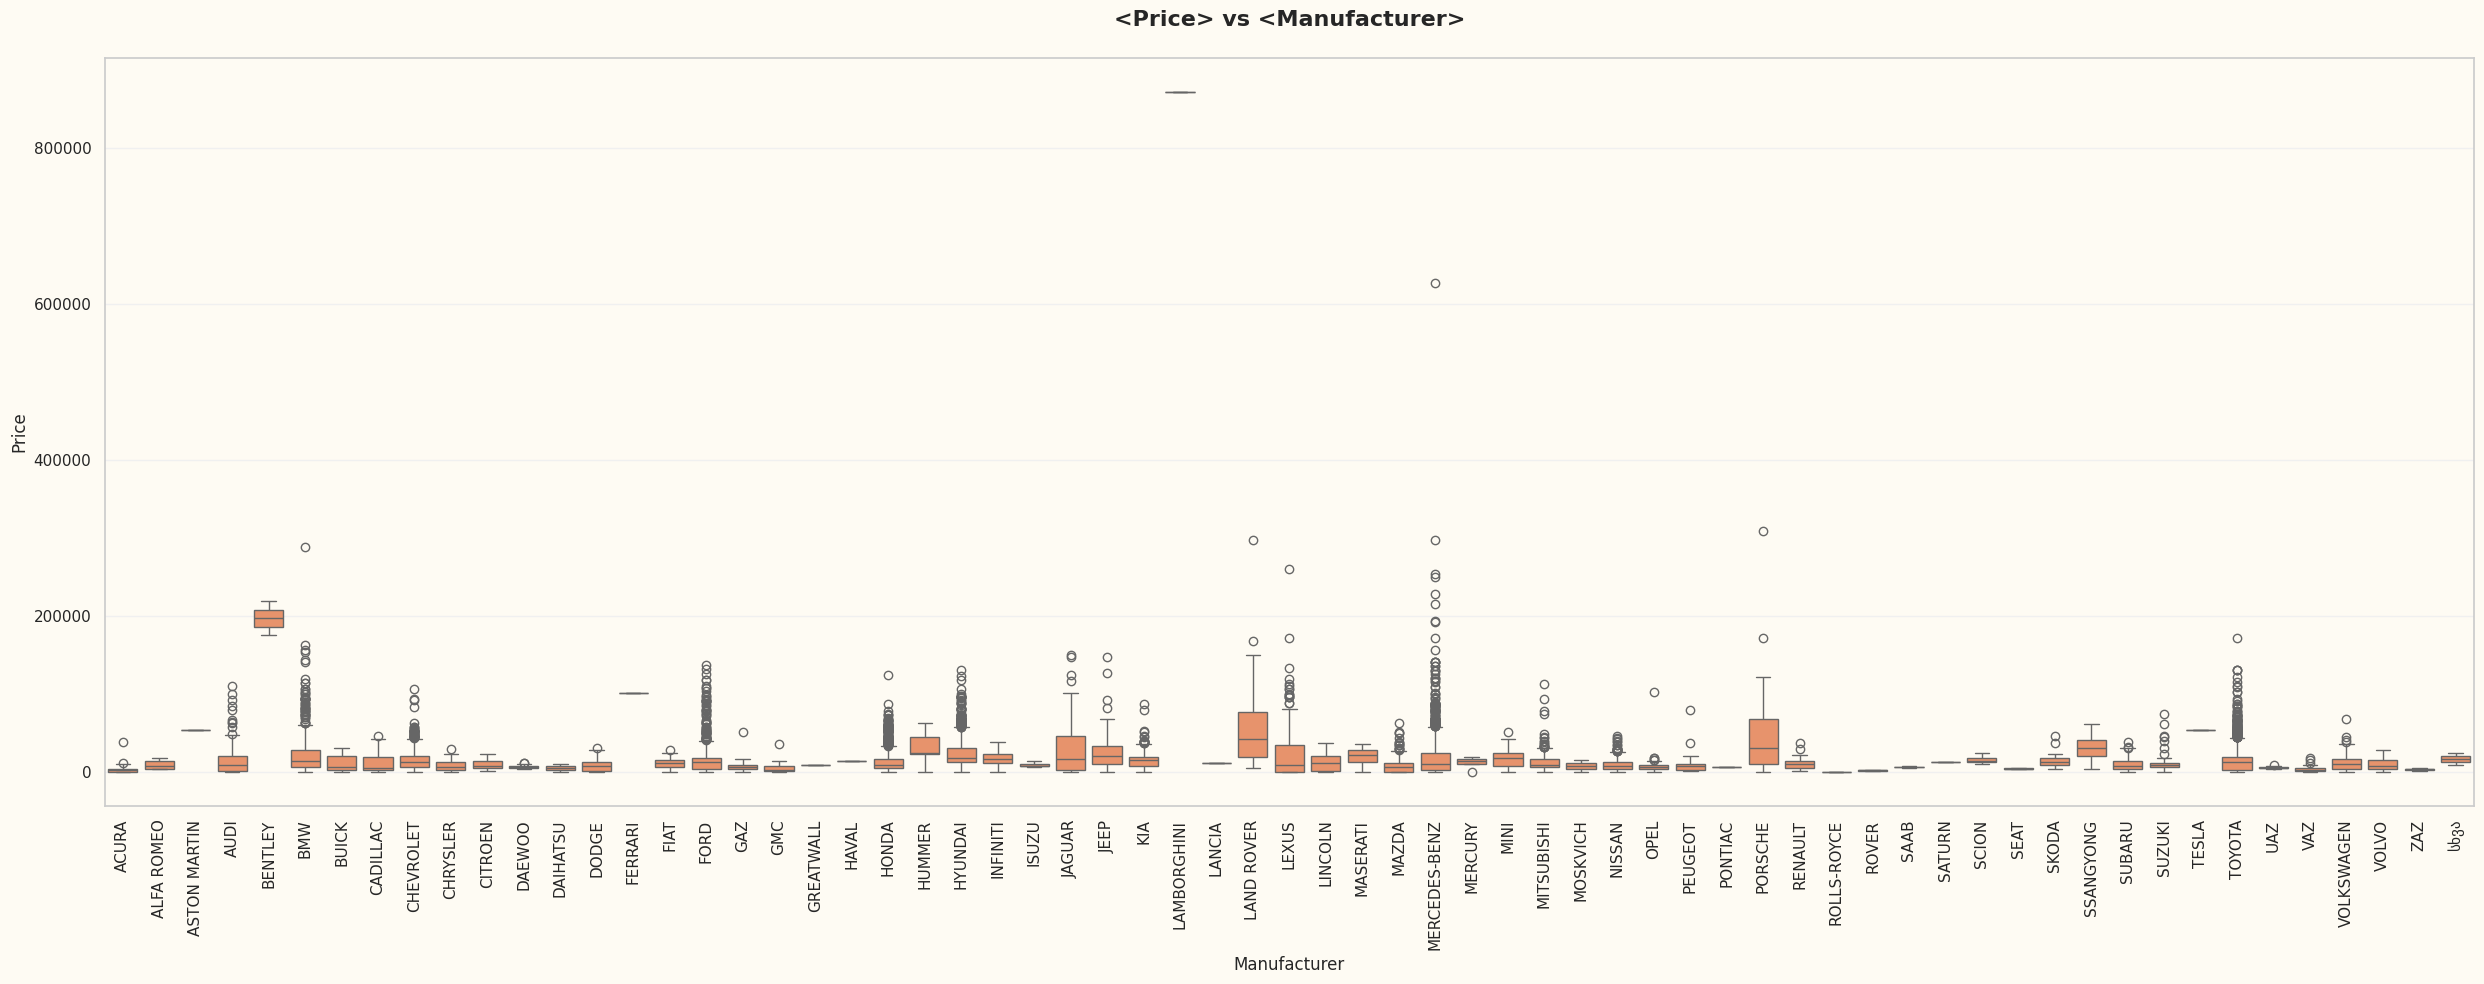

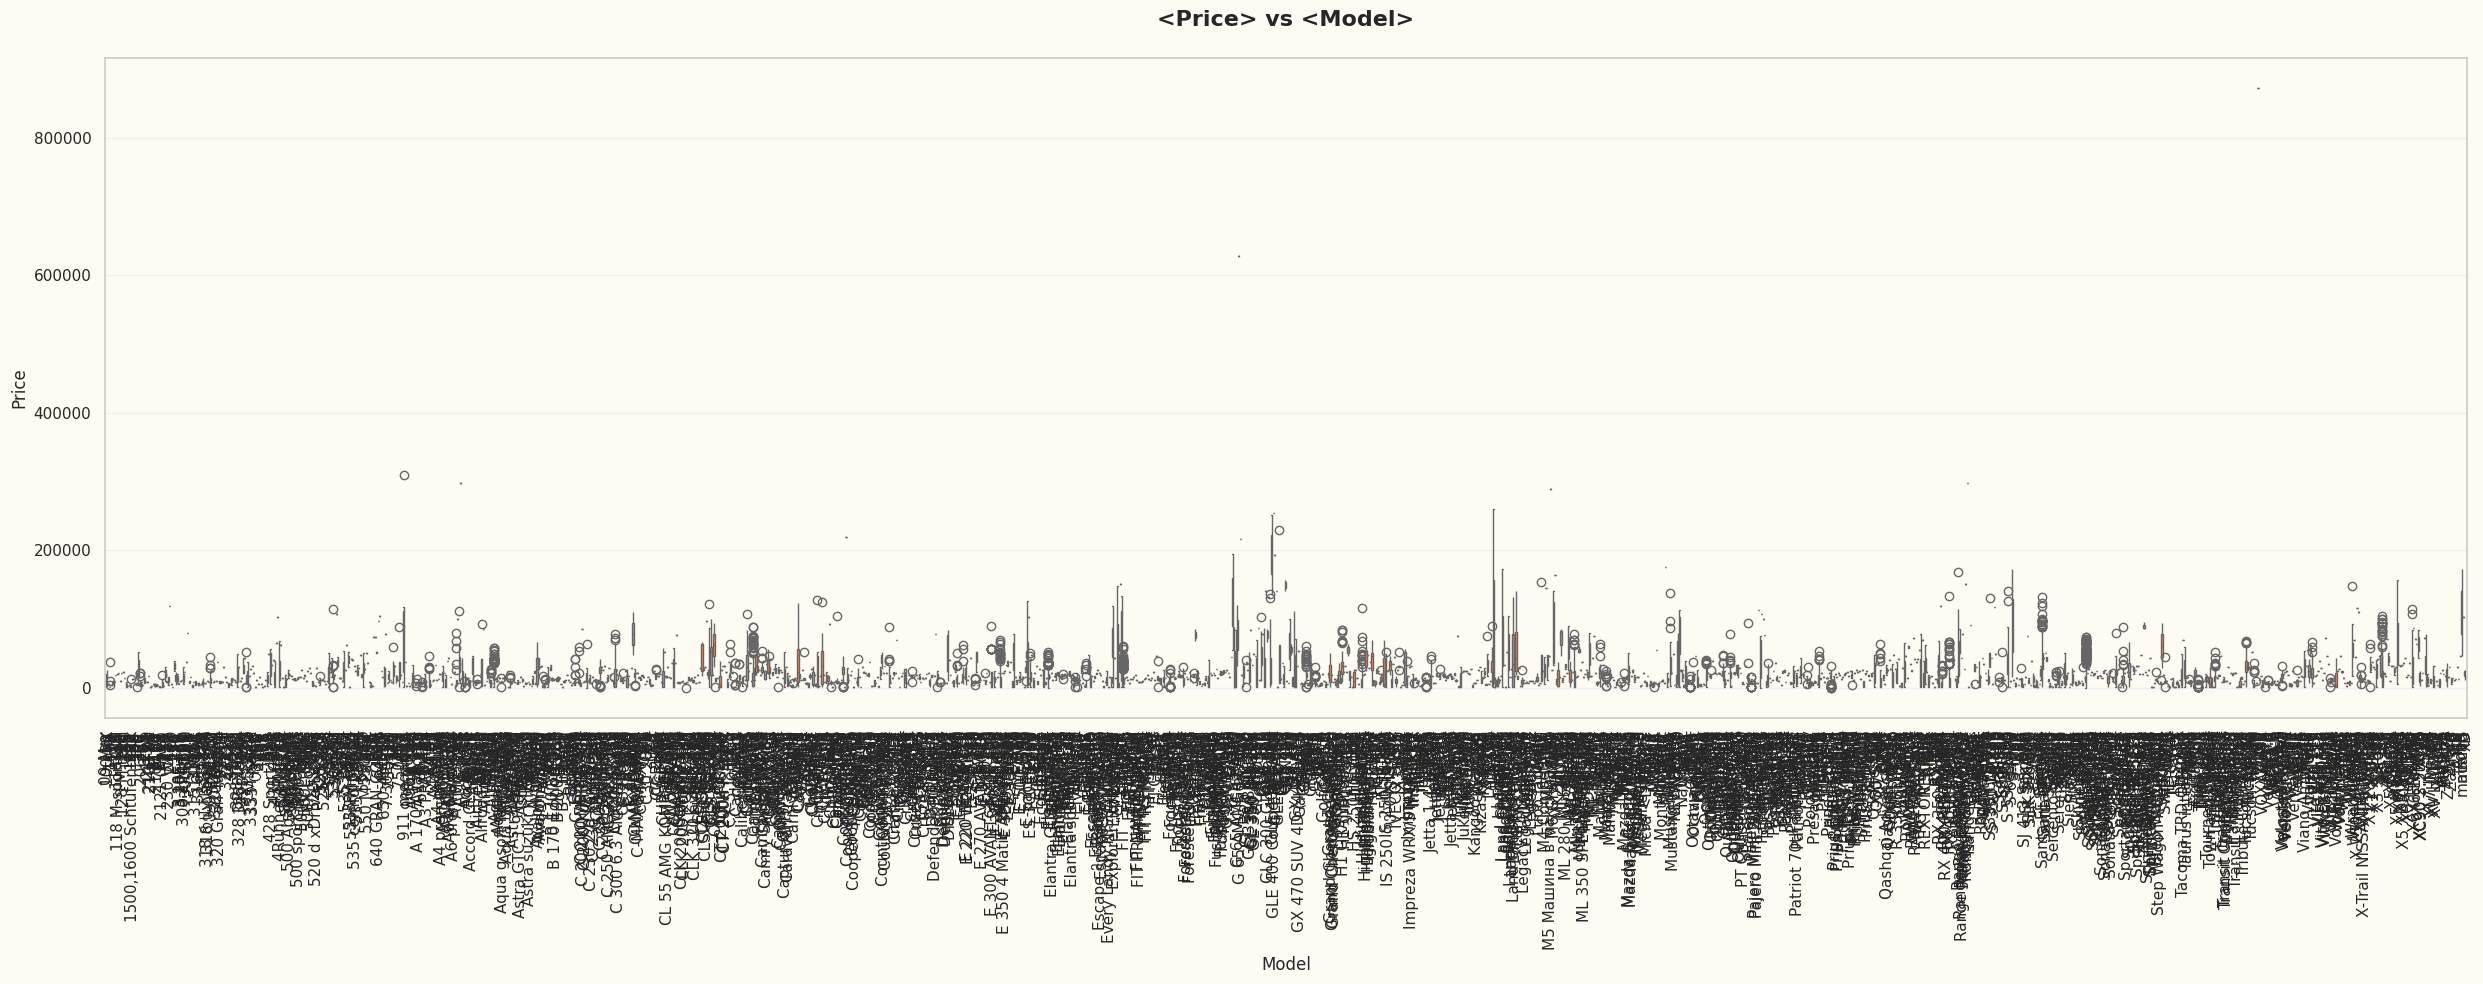

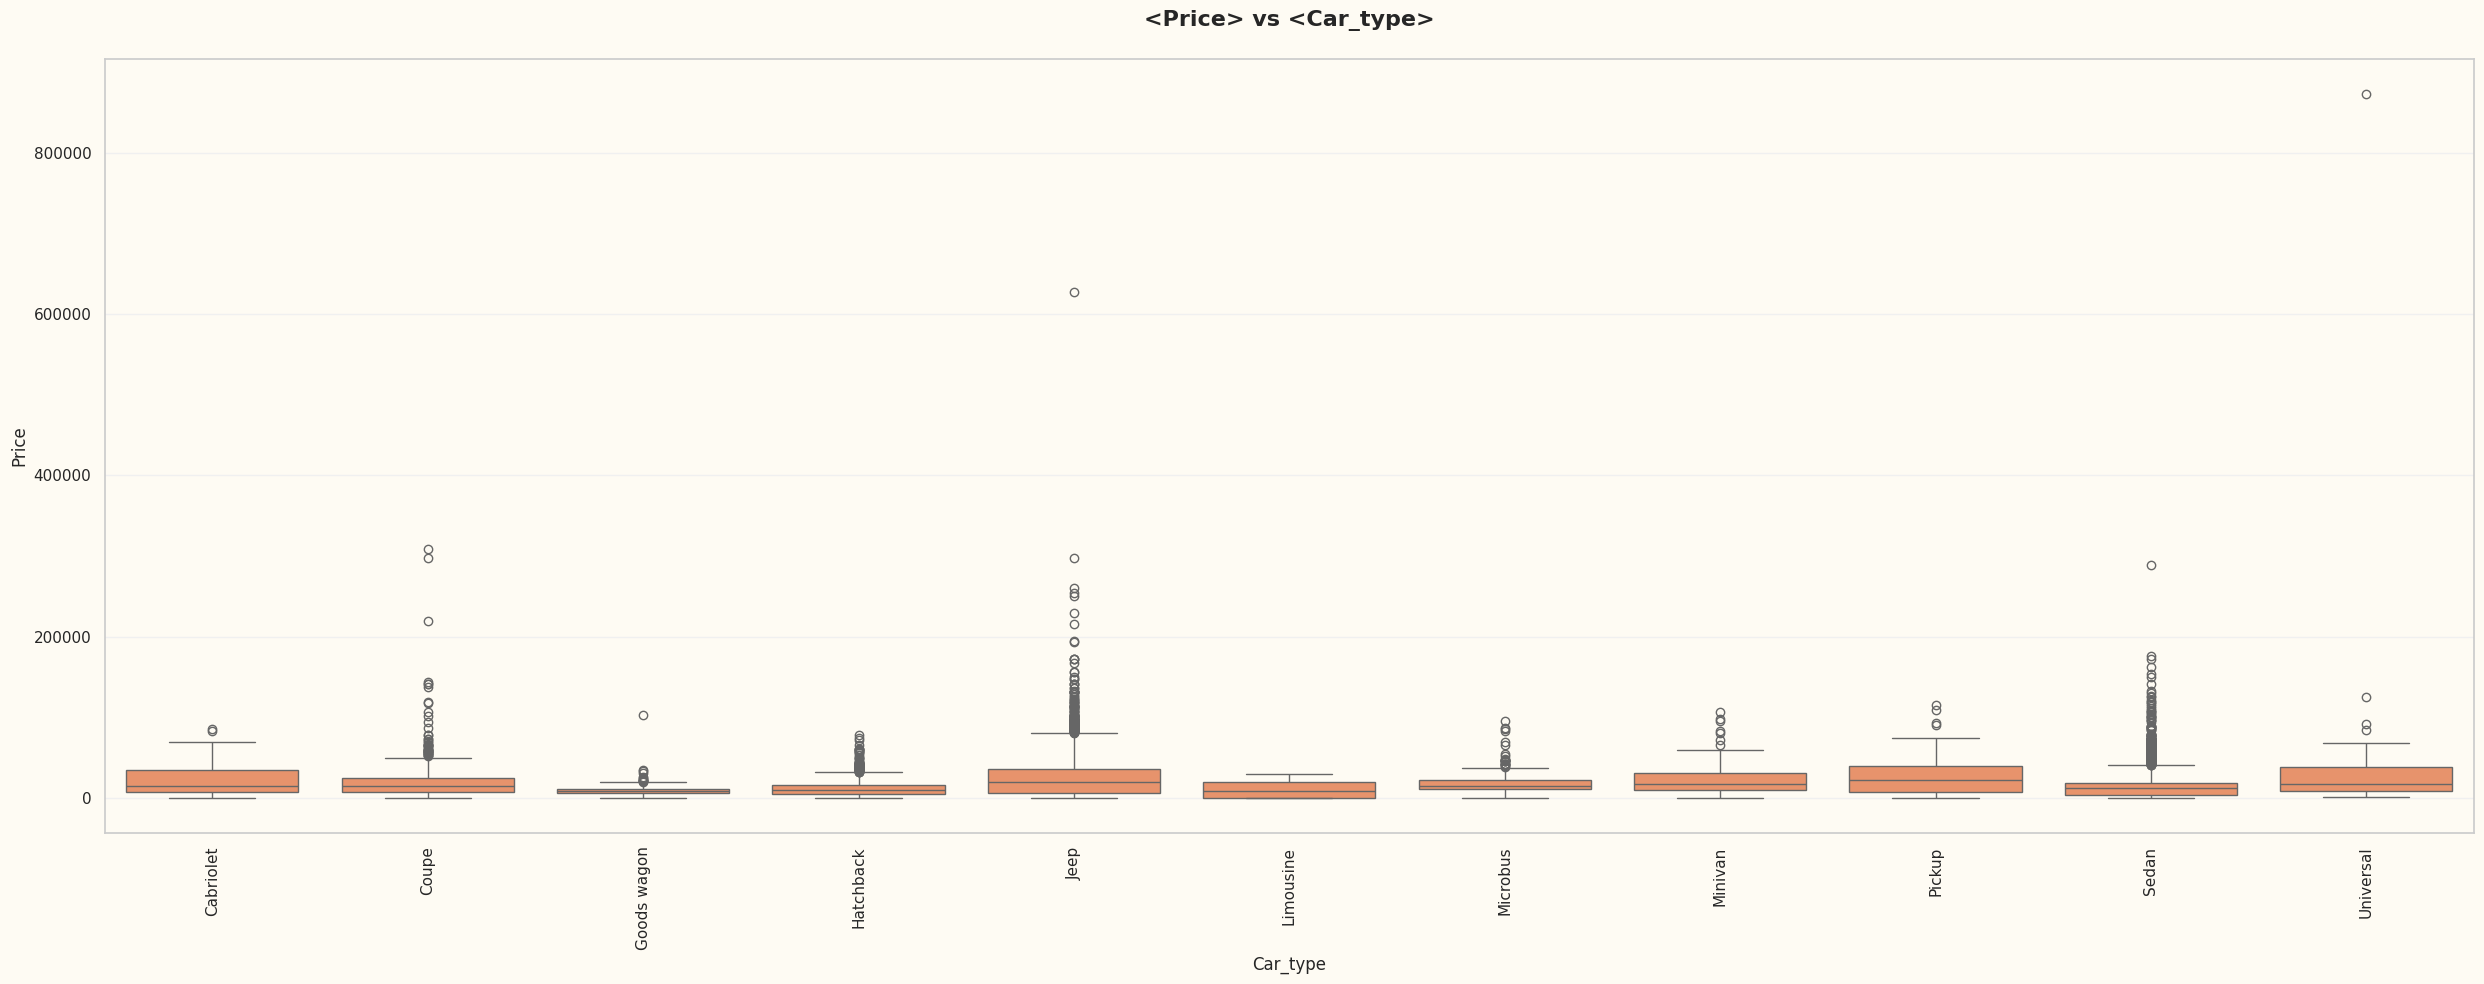

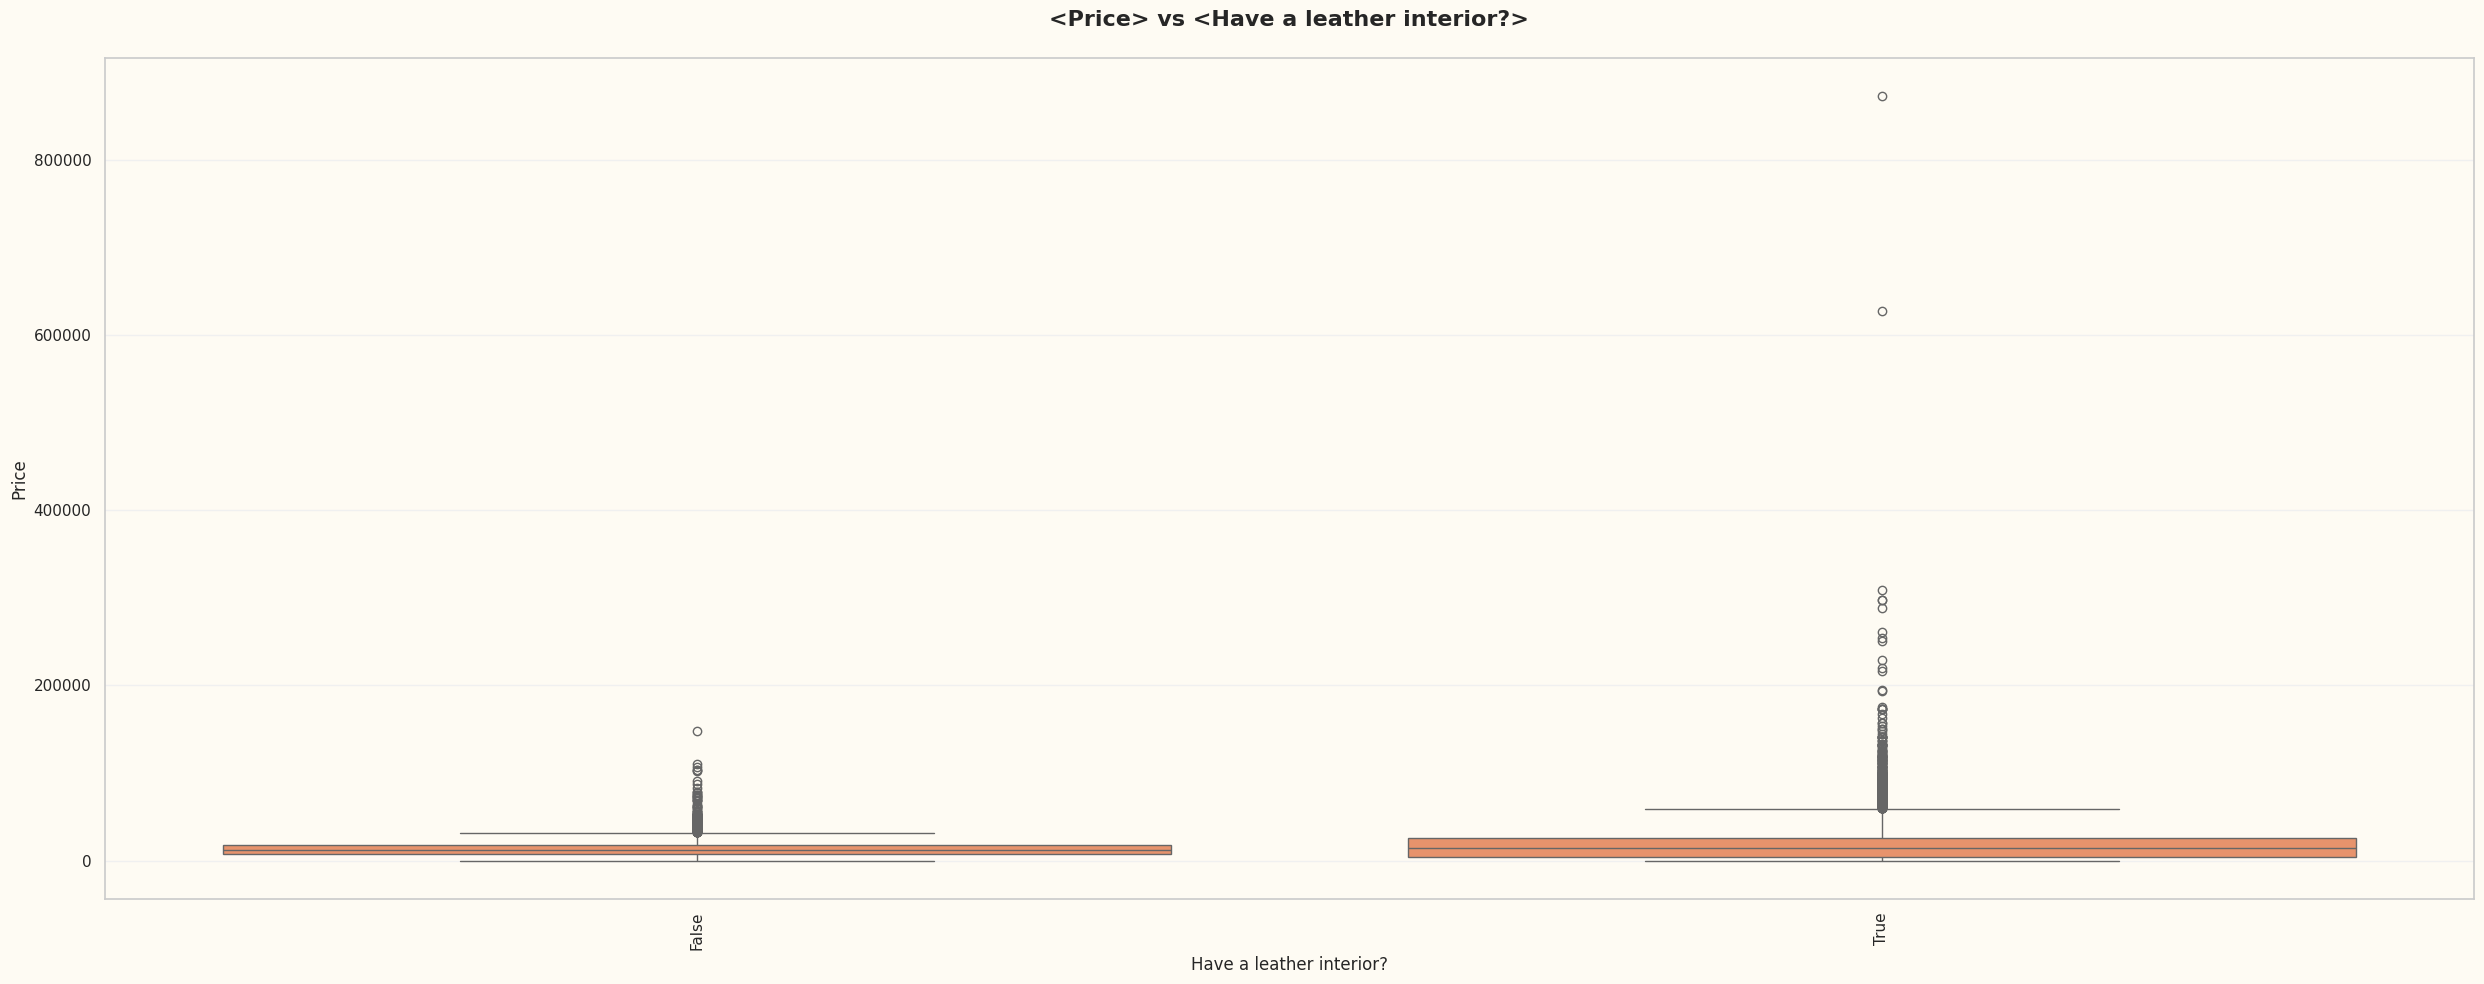

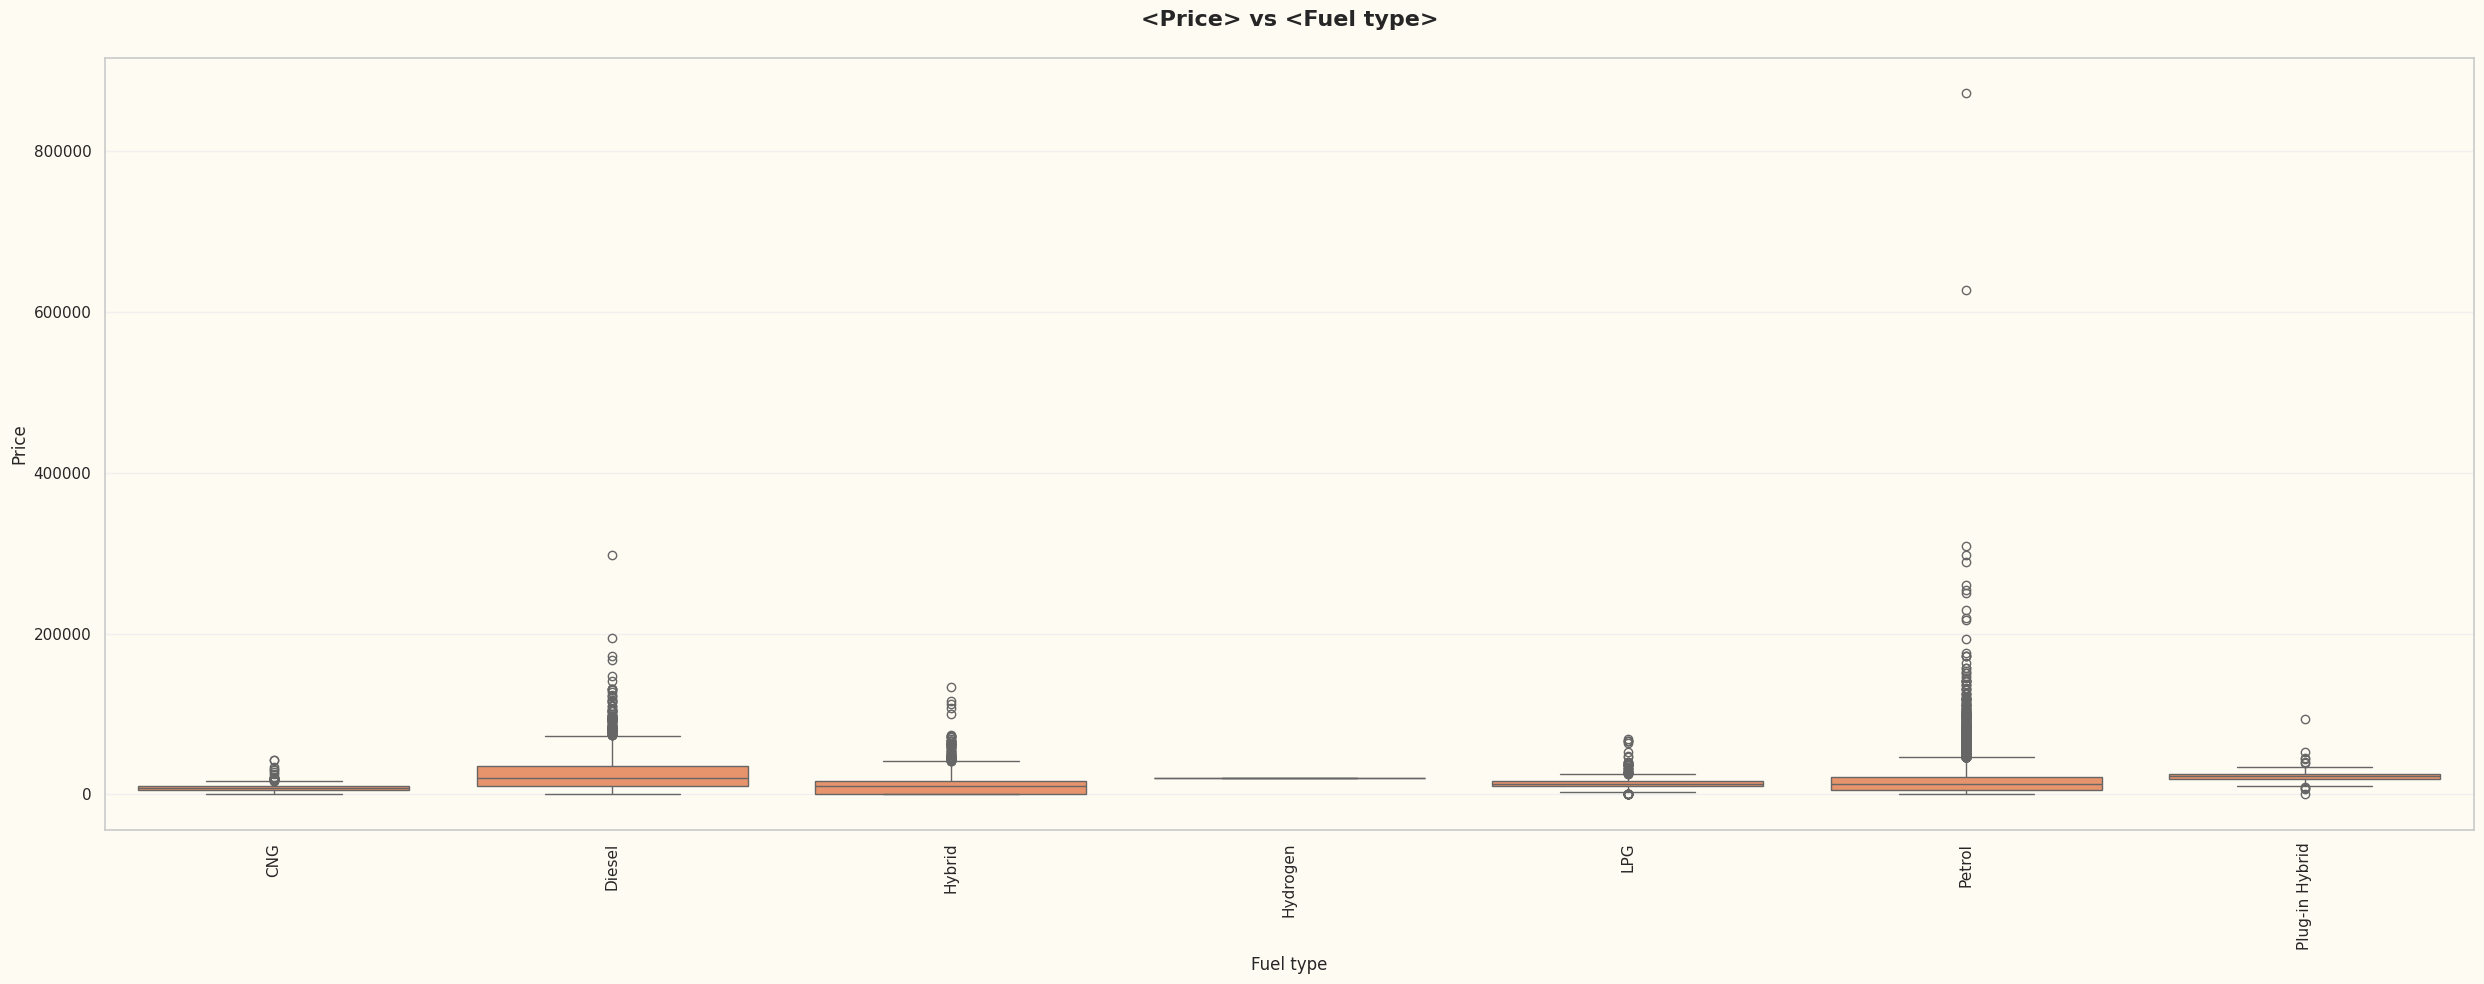

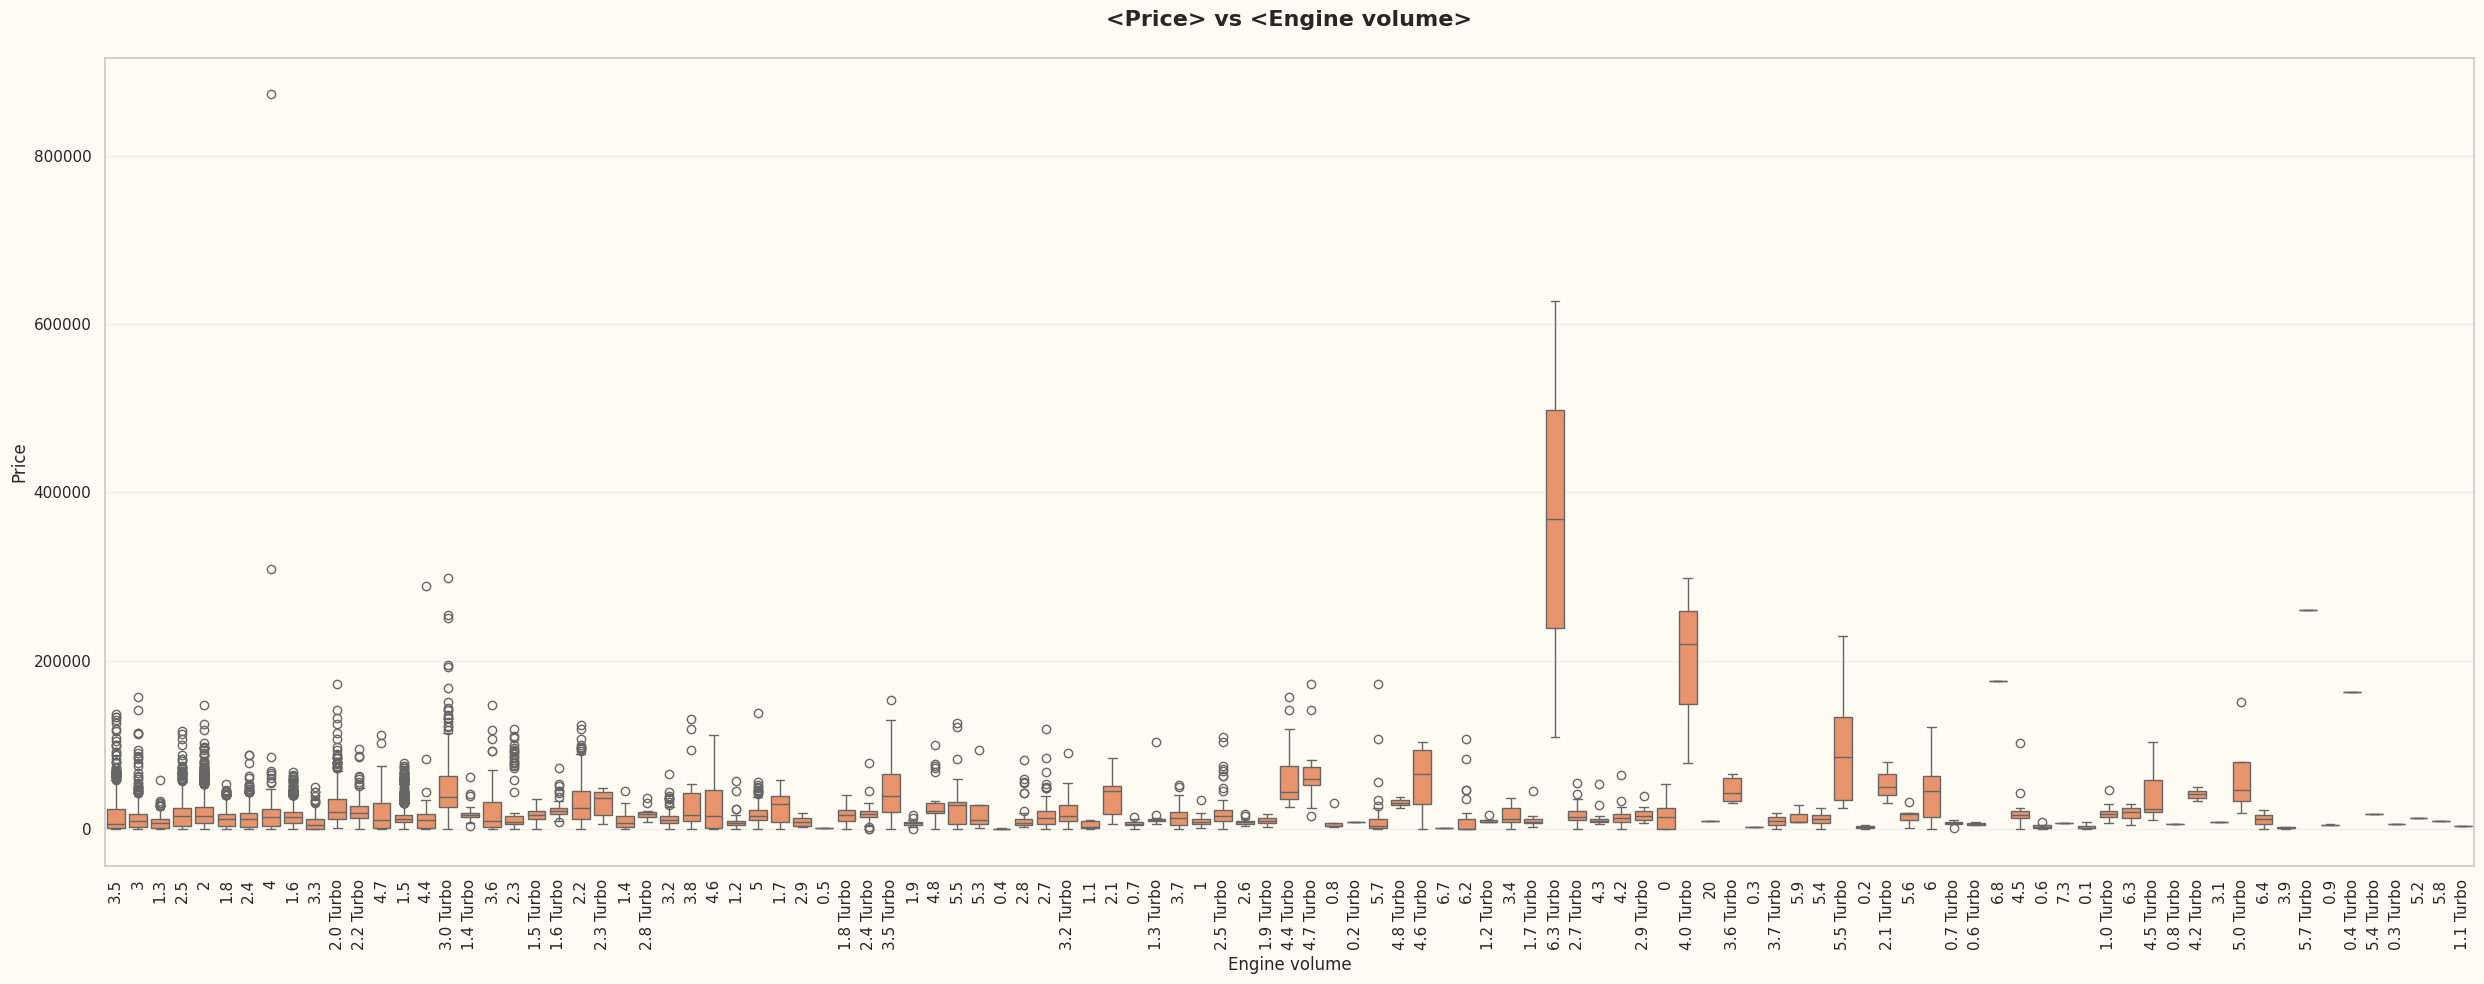

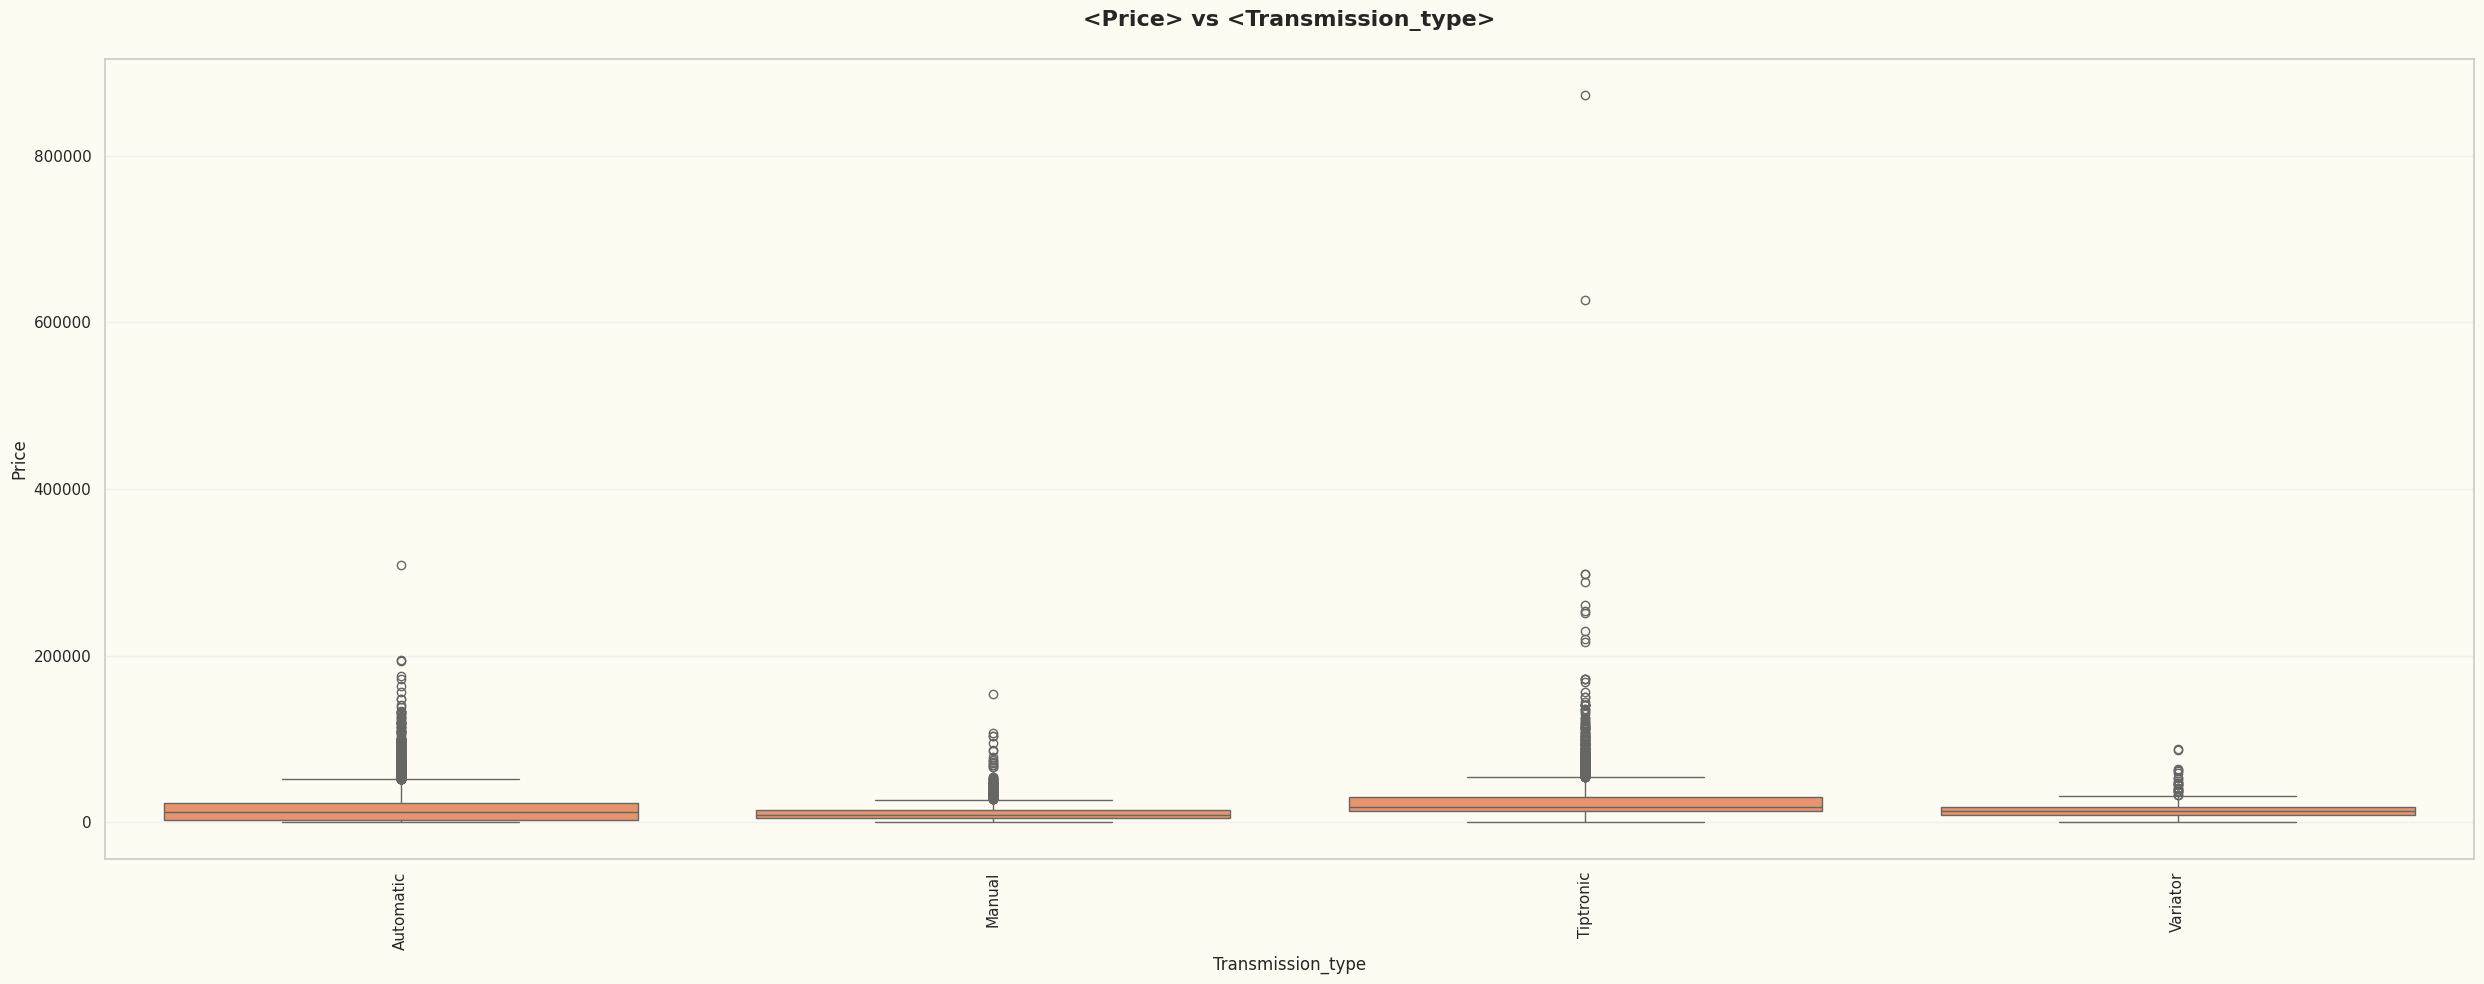

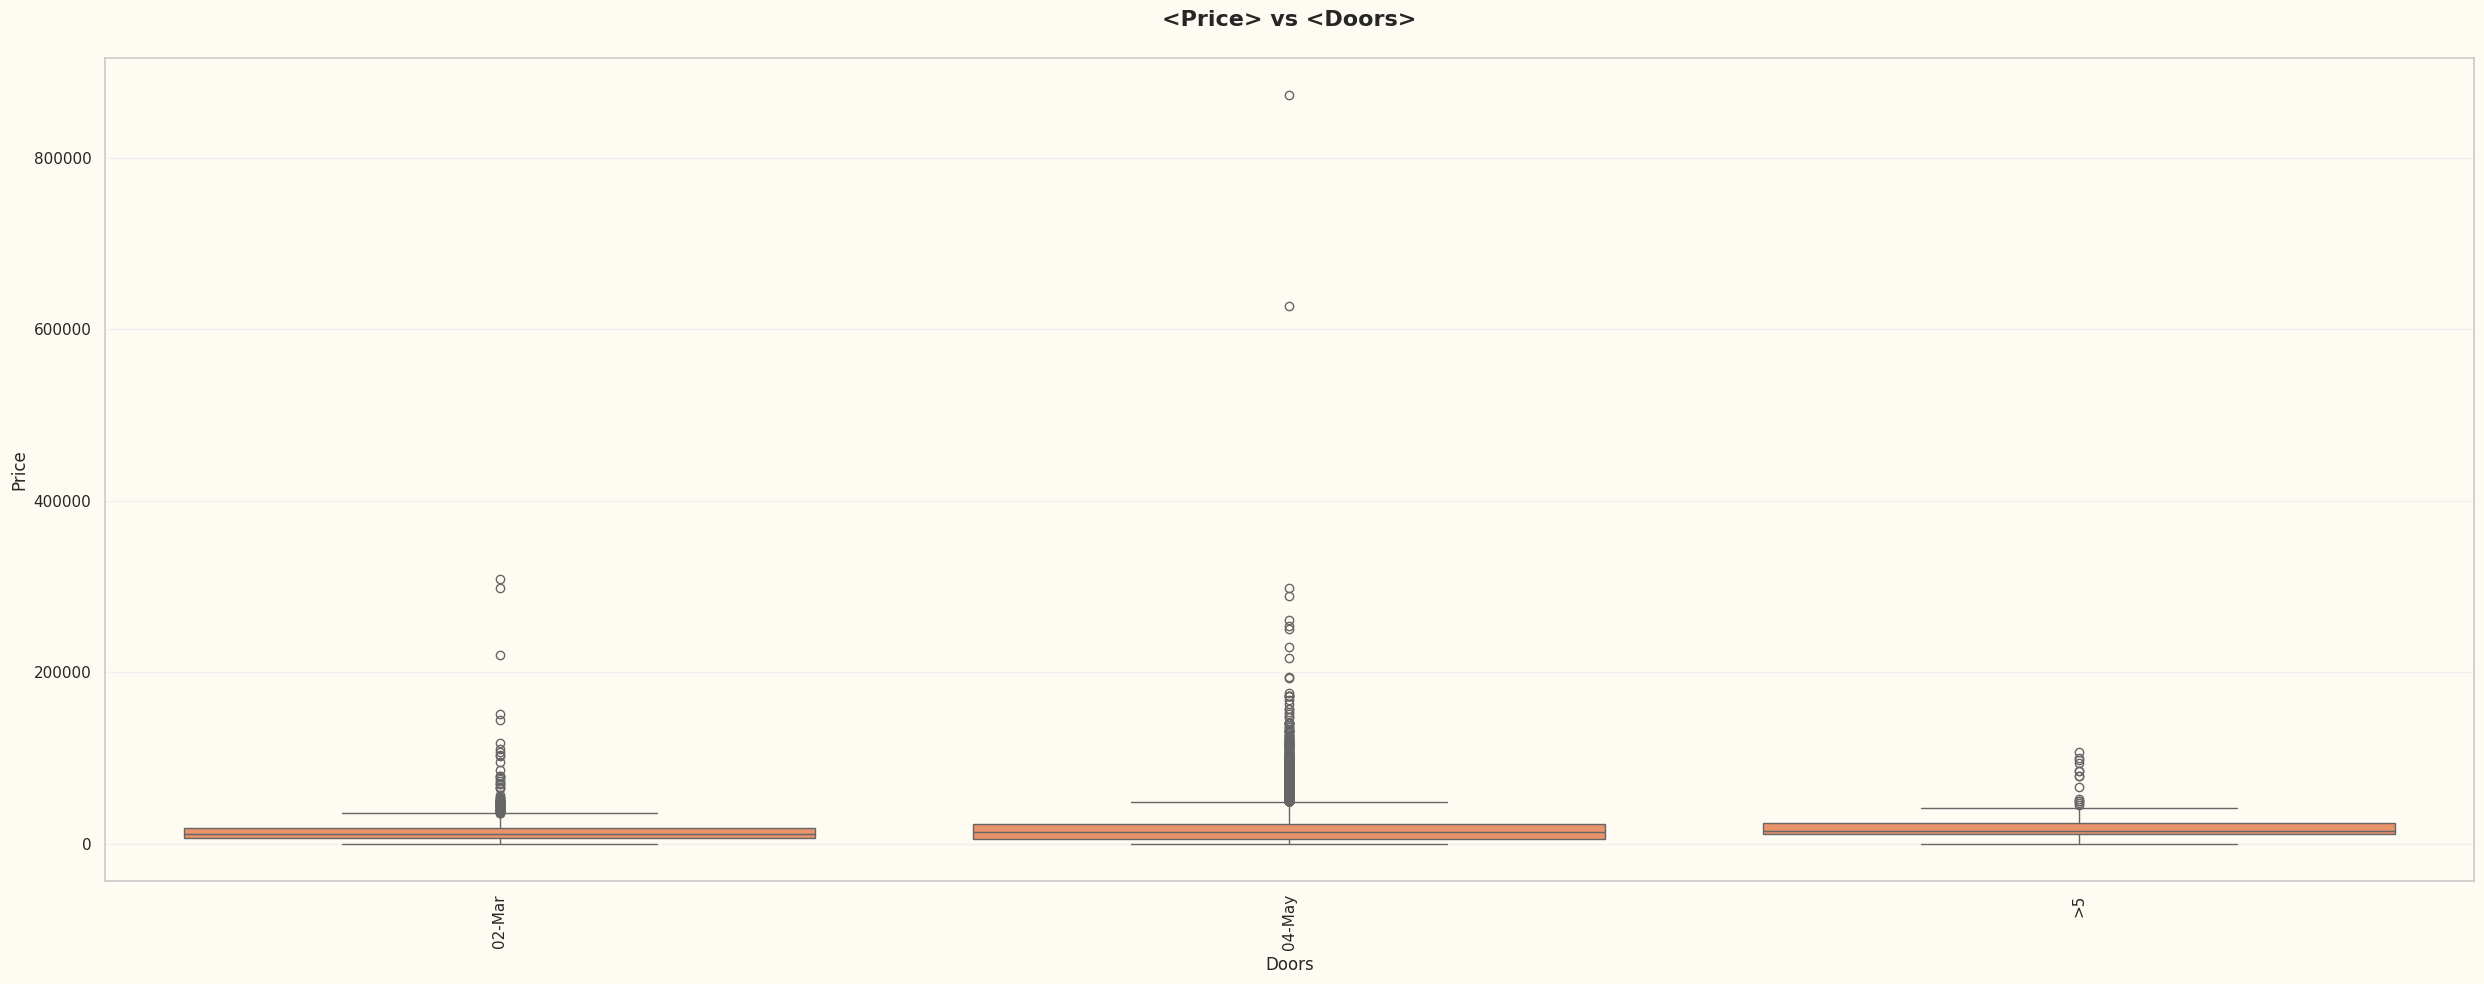

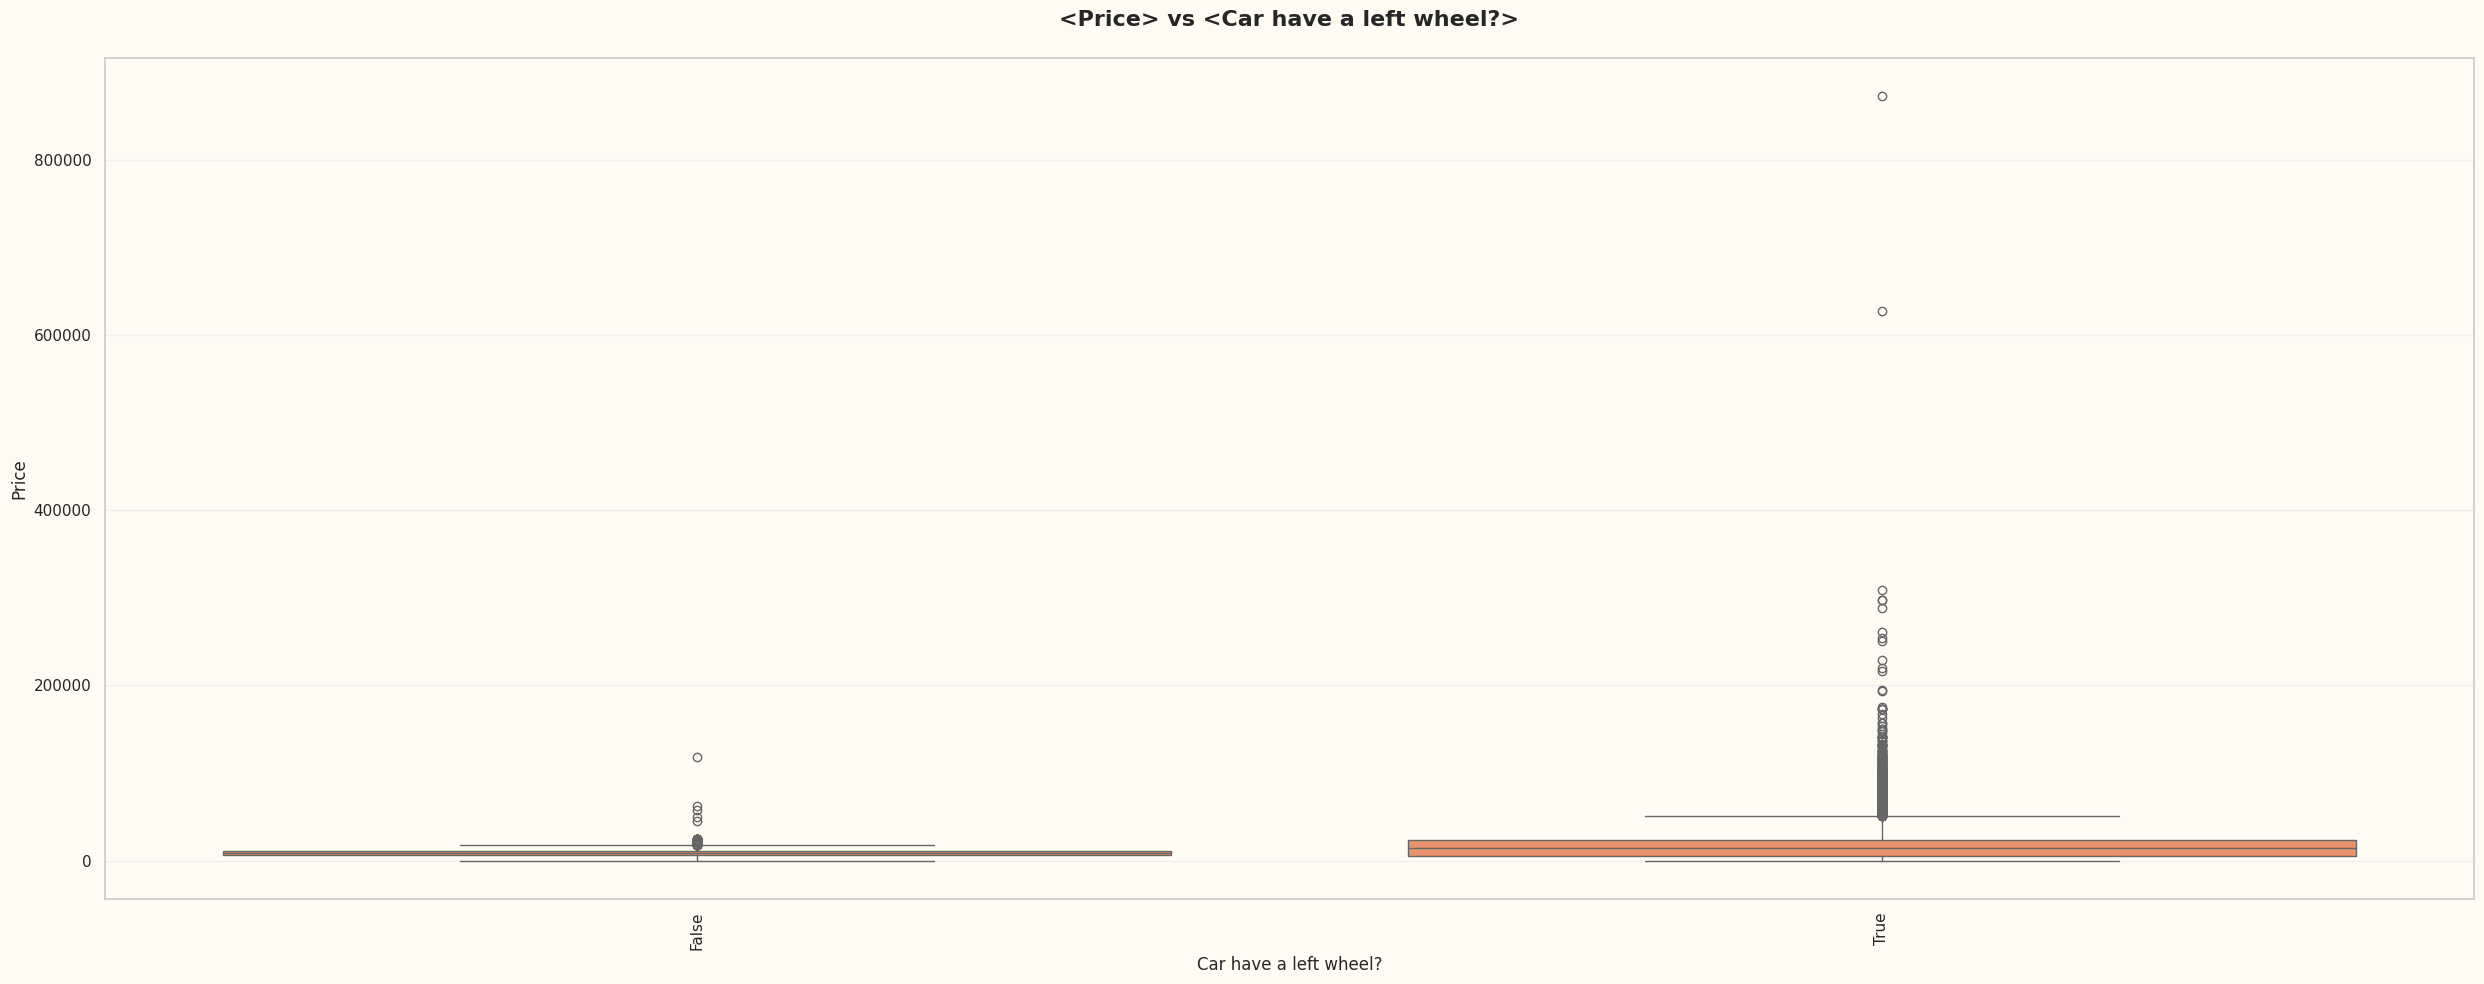

In [699]:
# включаем шрифт поддерживающий грузинские буквы, так как в таблице есть такие автомобили
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.sans-serif"] = ["DejaVu Sans", "Arial Unicode MS", "Liberation Sans"]

cat_ft = df_par.select_dtypes(exclude="number").columns

for features in cat_ft:
    n_cat = df_par[features].nunique()  # количество уникальных значений в признаке

    plt.figure(figsize=(25, 10))
    sns.boxplot(data=df_par, x=features, y="Price")
    plt.xticks(rotation=90)
    plt.title(f"<Price> vs <{features}>\n", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

_К сожалению в связи с огромным количеством уникальных значений в признаке `Model` взять информацию с графика не представляется возможным_. Но какие выводы можно сделать по оставшимся:

- Выбросы в большинстве построенных boxplot являются значениями дорогих премиальных автомобилей - **Lamborgini, Bently и т.д**.
- В среднем медианы по цене авто на каждом boxplot находятся довольно низко. Но есть идеально расположившийся boxplot в признаке Engine volume - 6.3 Turbo.

_Промежуточный вывод_ - на среднюю цену автомобиля наибольшее влияние из категориальных признаков оказывает бренд (Lamborgini, Bently, Mersedes-Benz) и объем двигателя (особенно 6.3 Turbo). Остальные же параметры и признаки оказывают влияние по **минимуму**.  
Но есть подозрение, что в признаке `Model` также есть большое влияние у определенных типов автомобилей. Кроме того вызывает подозрение достоверность данных в связи с тем, что в признаке `Car_type` две категории - _Jeep и Limousine_ должны обладать куда более высокой медианой, чем есть на самом деле.

Вернем шрифт на первоначальный.

In [700]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans", "Liberation Sans"]

Далее, поиск в интернете и подсказки от AI, направили меня на поиск модели для создания **ранжирования признаков по влиянию на цену**.  
Так была найдена библиотека `scikit-learn` откуда взята модель `RandomForestRegressor`.
Код ниже это процесс работы данной модели.

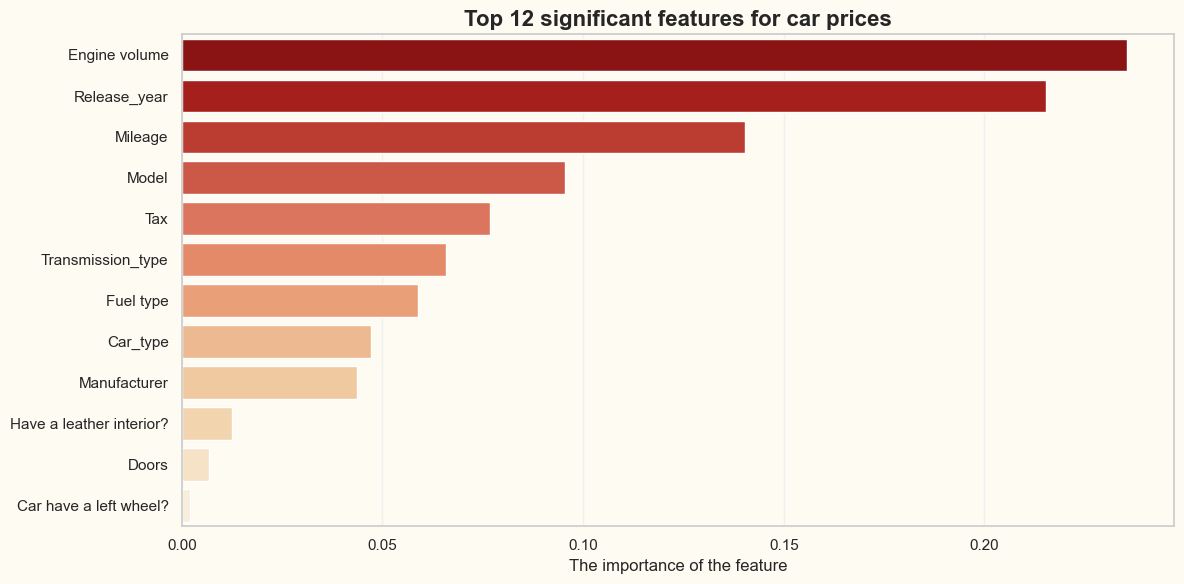

Ranking of features by importance:
 8. Engine volume             | importance: 0.2355
 4. Release_year              | importance: 0.2153
 9. Mileage                   | importance: 0.1403
 3. Model                     | importance: 0.0956
 1. Tax                       | importance: 0.0767
10. Transmission_type         | importance: 0.0659
 7. Fuel type                 | importance: 0.0588
 5. Car_type                  | importance: 0.0471
 2. Manufacturer              | importance: 0.0436
 6. Have a leather interior?  | importance: 0.0125
11. Doors                     | importance: 0.0067
12. Car have a left wheel?    | importance: 0.0020


In [701]:
from sklearn.ensemble import RandomForestRegressor


ft = [
    col for col in df_par.columns if col not in ["Price", "ID"]
]  # исключаем ID и Price как признаки из анализа

X = df_par[ft].copy()  # на ось X ставятся наши признаки
y = df_par["Price"]

X_encoded = X.copy()
for col in X_encoded.select_dtypes(exclude="number").columns:
    X_encoded[col] = (
        X_encoded[col].astype("category").cat.codes
    )  # перевод категориальных признаков в числа

model = RandomForestRegressor(
    random_state=10, n_estimators=100
)  # cама модель, где n_estimators - количество деревьев решений(каждое анализирует по-своему), random_state - только для воспроизводимости результатов (может быть любым)
model.fit(X_encoded, y)

feature_importance = pd.DataFrame(
    {"feature": ft, "importance": model.feature_importances_}
).sort_values(
    "importance", ascending=False
)  # сортировка по важности

plt.figure(figsize=(12, 6))
sns.barplot(
    data=feature_importance.head(12),
    x="importance",
    y="feature",
    hue="feature",
    palette="OrRd_r",
    legend=False,
)
plt.title("Top 12 significant features for car prices", fontsize=16, fontweight="bold")
plt.xlabel(
    "The importance of the feature",
)
plt.ylabel("")
plt.tight_layout()
plt.show()

# Выводим таблицу с результатами
print("Ranking of features by importance:")
print("=" * 50)
for i, row in feature_importance.iterrows():
    print(f"{i+1:2d}. {row['feature']:25} | importance: {row['importance']:.4f}")

Рассмотрим также корреляцию основных числовых признаков с помощью `3D scatterplot`.
Как мы выяснили основными будут - _Release year_ и _Mileage_.

In [702]:
if len(top_corr_ft) >= 2:
    fig = px.scatter_3d(
        df_par,
        x=top_corr_ft[0],
        y=top_corr_ft[1],
        z="Price",
        color="Price",
        title=f"3D scatter: <{top_corr_ft[0]}> vs <{top_corr_ft[1]}> vs <Price>",
        # template="seaborn",
        color_continuous_scale="OrRd_r",
    )
    fig.show()

_Промежуточный вывод_ - чем новее автомобиль и чем меньше у него пробег, тем формируемая цена - **выше**.
Как и требовалось доказать. Но, на графике также видны 2 точки, выбивающиеся из картины по причине сильного воздействия на цену другого признака - `Model`


---

#### 7) Итоги

Это было сложно и местами непонятно, но мы добрались до конца анализа данных!  

_Итог_ - задача была решена. Из графика barplot мы видим, что наибольшее влияние на стоимость автомобиля оказывает два признака `Engine_volume` и `Release_year`. Далее все идет по убыванию.  
_Какой вывод сделал лично я?_ - есть ощущение, что данные были синтетическими, так как в них на предыдущих этапах были странные выбросы - скорее похожие на ошибки, которые создавал человек. Кроме того присутствовали магические числа в некоторых признаках, а в признаке `Tax` и только там были пустые значения.  
**Все это наводит на мысли об искуственности данных**

Но при этом же топ-3 признака в итоговой модели показывают на близкие к реальности факты:
- Чем старше автомобиль, тем он дешевле (исключая старые ретро-автомобили, которые не укладываются в такую модель).
- Чем больше у авто объем двигателя (а соответственно и мощность), тем он дороже. Причем это фактор №1 исходя из ранжирования.
- Чем меньше у автомобиля километраж, тем он дороже.

_Что меня удивило_:
- Удивил факт того, что **тип автомобиля**, **производитель** и **модель** - являются не самыми главными факторами в цене автомобиля. Но стоит учитывать, что модель и производитель решают среднюю цену, ибо Lamborgini и UAZ их медиана цены находится в разных местах.
- Также удивило, что тип руля оказывает наименьшее влияния на цену. Хотя при покупке машины из-за рубежа, особенно с Японии, если у машины правый руль, то и стоит она дешевле.

**ВЫВОД** - в большинстве своем анализ показал реальную картину формирования стоимости автомобиля, но есть подозрения в том, что взятый dataset с kaggle имеет искусственное происхождение.